# MLHB Workshop 5 - Exploration, Strategic Behavior, and Dynamics

**Neccesary utility code from last workshop.**

No need to understand how it works.

Note: we added to the ```plot_graph``` function the option to plot smoothed graphs (```smooth=True```). 



In [1]:
# Reclab installation. this may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

fatal: destination path '/usr/local/lib/python3.7/dist-packages/reclab2' already exists and is not an empty directory.


In [2]:
import numpy as np
import reclab
import matplotlib.pyplot as plt
from reclab.environments import Topics
from reclab.environments.latent_factors import LatentFactorBehavior
from reclab.recommenders import TopPop
from reclab.recommenders.libfm import LibFM
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

In [3]:
import scipy.sparse
import wpyfm
from reclab.recommenders.libfm import LibFM

class LibFM_MLHB(LibFM):
  def _predict(self, user_item):  # noqa: D102
    # Create a test_inputs array that can be parsed by our output function.
    test_inputs = []
    data = []
    row_col = [[], []]
    for row, (user_id, item_id, rating_context) in enumerate(user_item):
        user_features = self._users[user_id]
        item_features = self._items[item_id]
        row_col[0].append(row)
        row_col[1].append(user_id)
        data.append(1)
        for i, feature in enumerate(user_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + i)
            data.append(feature)
        row_col[0].append(row)
        row_col[1].append(self._max_num_users + len(user_features) + item_id)
        data.append(1)
        for i, feature in enumerate(item_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + i)
            data.append(feature)
        for i, feature in enumerate(rating_context):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + len(item_features) + i)
            data.append(feature)

    test_inputs = scipy.sparse.csr_matrix((data, row_col),
                                          shape=(len(user_item), self._num_features))
    test_data = wpyfm.Data(test_inputs, np.zeros(test_inputs.shape[0]), has_xt=self._has_xt)
    predictions = self._model.predict(test_data)

    return predictions

  def reset(self, users=None, items=None, ratings=None):  # noqa: D102
    np.random.seed(0)
    rating_inputs = scipy.sparse.csr_matrix((0, self._num_features))
    rating_outputs = np.empty((0,))
    self._train_data = wpyfm.Data(rating_inputs, rating_outputs, has_xt=self._has_xt)
    super().reset(users, items, ratings)
    self._model.train(self._train_data)

In [4]:
def RMSE(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

def avg_rec_rating(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  sum = 0
  for i, item in enumerate(recommendations):
    sum += true_ratings[i, item[0]]
  return sum/(len(all_users))

In [5]:
from tqdm import tqdm

"""
params:
env - reclab environment.
recommender - reclab recommender.
steps - number of simulation iterations. in each step the recommender recommends items to online users and gets their true ratings.
rpu - recommendations per user.
retrain - retrain model after each step (True) or not (False).
callbacks - a list of functions. each gets (env, recommender) as arguments. before every timestep all callbacks are invoked.
reset - reset the environment and recommender at the beggining of the simulation (True) or not (False)

return:
a list of lists. Each list contains the return values of its corresponding callback for all timesteps.
"""
def simulation(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True, seed: int = 0):
  if reset:
    np.random.seed(seed)
    env.seed(seed)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      items, users, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      items, users, ratings = env.reset()
      env._affinity_change = temp
    else:
      items, users, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
        recommender._model.train(recommender._train_data) # Specificaly for libfm.
  return results

In [6]:
# A fix for the reclab class because they have an error
class LatentFactorBehavior_MLHB(LatentFactorBehavior):
  def _get_dense_ratings(self):
    ratings = (self._user_factors @ self._item_factors.T + self._user_biases[:, np.newaxis] +
              self._item_biases[np.newaxis, :] + self._offset)
    # Compute the boredom penalties.
    item_norms = np.linalg.norm(self._item_factors, axis=1)
    normalized_items = self._item_factors / item_norms[:, np.newaxis]
    similarities = normalized_items @ normalized_items.T
    similarities -= self._boredom_threshold
    similarities[similarities < 0] = 0
    penalties = self._boredom_penalty * similarities
    for user_id in range(self._num_users):
      for item_id in self._user_histories[user_id]:
        if item_id is not None:
          ratings[user_id] -= penalties[item_id][0]
    return ratings

  def _get_rating(self, user_id, item_id):
    raw_rating = (self._user_factors[user_id] @ self._item_factors[item_id]
                  + self._user_biases[user_id] + self._item_biases[item_id] + self._offset)

    # Compute the boredom penalty.
    boredom_penalty = 0
    for item_id_hist in self._user_histories[user_id]:
      item_factor = self._item_factors[item_id_hist][0]
      if item_factor is not None:
        similarity = ((self._item_factors[item_id] @ item_factor)
                      / np.linalg.norm(item_factor)
                      / np.linalg.norm(self._item_factors[item_id]))
        if similarity > self._boredom_threshold:
          boredom_penalty += (similarity - self._boredom_threshold)
    boredom_penalty *= self._boredom_penalty
    rating = np.clip(raw_rating - boredom_penalty + self._dynamics_random.randn() *
                      self._noise, 1, 5)

    return rating

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%config InlineBackend.figure_format = 'retina'

# This is an auxillery function that, given some lists of values, plots the values of each list as a function of the index of the values.
def plot_graphs(*lists, title=r'recommendation model evaluation at different timesteps', legend=True, smooth=True):
  fig,ax = plt.subplots()
  for i,l in enumerate(lists):
    if smooth:
      l = savgol_filter(l, 21, 3)
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=str(i+1)
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  if legend:
    ax.legend()

  plt.show()

# Part 1: The effects of exploration
Up until now all recommendation models we considered were greedy in the sense that they always recommended items having the highest predicted value. In this section we will explore other recommendation policies (which are not fully greedy) and explore how they effect different system and user performance metrics.


## 1.1 Vanilla
Reclab includes an implementation of an $\epsilon$-greedy recommender: it recommends the item having the highest predicted score w.p. $1-\epsilon$, and an item selected uniformly at random w.p. $\epsilon$.

### 1.1.1 Simulation
Run a simulation with $\epsilon \in \{0, 0.15, 0.3\}$. Plot the losses of all three simulations (overlaid on a single figure).
Then, add plots for the average ratings graphs of all three simulations (also on the same figure). Use the ```RMSE``` and ```avg_rec_rating``` callbacks.

Note: To use an $\epsilon$-greedy recommender in reclab, initialize it with the arguments ```type='eps_greedy'``` and ```eps=```$\epsilon$. Also remember to create a new recommender for each simulation.

In [8]:
NUM_USERS = 100
NUM_ITEMS = 100
STEPS = 130

# environment to be used
env_params = {"num_topics": 10,
              "num_users": NUM_USERS,
              "num_items": NUM_ITEMS,
              "rating_frequency": 0.2,
              "num_init_ratings": NUM_USERS*NUM_ITEMS//100,
              "topic_change": 0}
env = Topics(**env_params)

epsilon=0, repeat=0


100%|██████████| 130/130 [00:26<00:00,  4.86it/s]


epsilon=0, repeat=1


100%|██████████| 130/130 [00:26<00:00,  4.85it/s]


epsilon=0, repeat=2


100%|██████████| 130/130 [00:26<00:00,  4.87it/s]


epsilon=0.15, repeat=0


100%|██████████| 130/130 [00:26<00:00,  4.98it/s]


epsilon=0.15, repeat=1


100%|██████████| 130/130 [00:26<00:00,  4.99it/s]


epsilon=0.15, repeat=2


100%|██████████| 130/130 [00:26<00:00,  4.96it/s]


epsilon=0.3, repeat=0


100%|██████████| 130/130 [00:25<00:00,  5.10it/s]


epsilon=0.3, repeat=1


100%|██████████| 130/130 [00:25<00:00,  5.04it/s]


epsilon=0.3, repeat=2


100%|██████████| 130/130 [00:25<00:00,  5.10it/s]


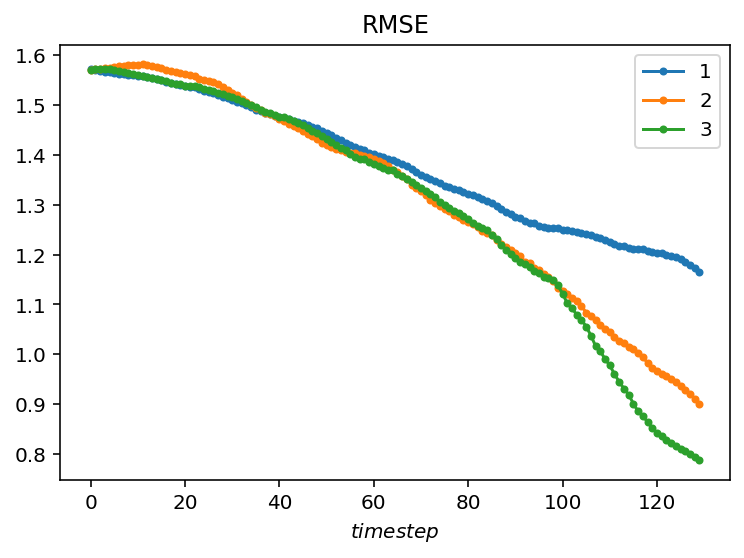

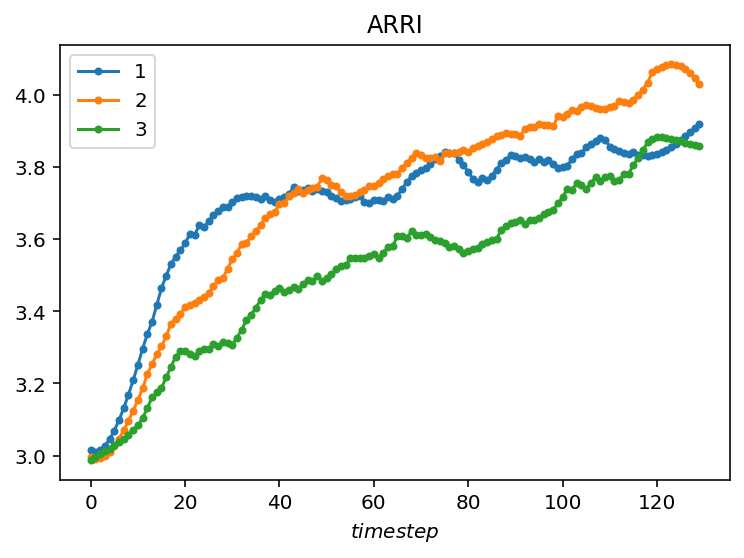

In [9]:
rmses = {
    0: [],
    0.15: [],
    0.3: []
}
arris = {
    0: [],
    0.15: [],
    0.3: []
}

REPEATS = 1
for epsilon in (0, 0.15, 0.3):
  recommender = LibFM_MLHB(type='eps_greedy',
                        eps=float(epsilon),
                        num_user_features=0,
                        num_item_features=0,
                        num_rating_features=0,
                        max_num_users=NUM_USERS,
                        max_num_items=NUM_ITEMS,
                        seed=0)
  
  for repeat in range(REPEATS):
    # run simulation
    print(f"epsilon={epsilon}, repeat={repeat}")
    losses, avg_ratings = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[RMSE, avg_rec_rating], reset=True, seed=repeat)
    rmses[epsilon].append(losses)
    arris[epsilon].append(avg_ratings)

mean_rmses = {
    0: [],
    0.15: [],
    0.3: []
}
mean_arris = {
    0: [],
    0.15: [],
    0.3: []
}
for epsilon in (0, 0.15, 0.3):
  mean_rmses[epsilon] = list(np.mean(np.asarray(rmses[epsilon]), axis=0))
  mean_arris[epsilon] = list(np.mean(np.asarray(arris[epsilon]), axis=0))

mean_rmses_vals = list(mean_rmses.values())
mean_arris_vals = list(mean_arris.values()) 
plot_graphs(*mean_rmses_vals, title="RMSE")
plot_graphs(*mean_arris_vals, title="ARRI")

### 1.1.2 Results
Explain your results here.

**Answer**: The epsilon-greedy algorithm offers the known exploration vs. exploitation trade-off, depending on the value of epsilon. epsilon=0 means we always exploit the knowledge we already have, not exploring new areas, not nessesarily fitting the data correctly. The more we increase epsilon the more exploration we perform, learning more about the true data but less exploiting this knowledge. The model with espilon=0 started strong, improving the average rating quickly, but then stuck on a local maximum, not able to explore new opportunities. The model with the highest epsilon explores too much, starting slow during exploration, but not using its gain knowledge enough. The mean model performs the best, reflecting a good saddle point in this trade-off; exploring the data, and exploiting this knowledge, scoring the highest average rating on the long run.

## 1.2 Boredom

**Reminder**: In reclab's ```Topics``` environment, a user's $u$ rating for an item $i$ at time $t$ is modeled as:
$r_t(u, i) = clip(\pi_t(u, k_i))$
where $k_i$ is the topic of item $i$, $\pi$ is a score function and $clip$ turncates the score to be between $1$ and $5$.

In this part you will explore what happens when users get *bored*.
Bordeom occurs when users are repeatedly recommended the same topic in a short time span. Boredom relies on three parameters:
* memory length $m$
* boredom threshold $\tau$
* boredom penalty $\lambda$

If a user observes the same topic more than $\tau$ times within the last $m$ timesteps, their ratings is penalized by $\lambda$.
Specifically:
$$
  r_t(u, i) = clip(\pi(u, k_i) - \lambda A_i(\tau,m))
$$
where
$A_i(\tau,m)=1$ if topic $k_i$ was observed more than $\tau$ times within $m$ previous timesteps, and 0 otherwise.

The Topics-dynamic reclab environment supports boredom effects. 

### 1.2.1 Simulation
Run an epsilon-greedy simulation for for $\epsilon \in \{0, 0.15, 0.3\}$ and $m = 6, \tau = 3, \lambda = 3$. 

Note: The arguments to ```Topics``` corresponding to $m, \tau, \lambda$ are ```memory_length, boredom_threshold, boredom_penalty``` respectively. Use the same environment and recommender parameters as previous section.

In [10]:
NUM_USERS = 100
NUM_ITEMS = 100
STEPS = 130

# environment to be used
env_params = {
  "num_topics": 10,
  "num_users": NUM_USERS,
  "num_items": NUM_ITEMS,
  "rating_frequency": 0.2,
  "num_init_ratings": NUM_USERS*NUM_ITEMS//100,
  "topic_change": 0,
  "memory_length": 6,
  "boredom_threshold": 3, 
  "boredom_penalty": 3,
}
env = Topics(**env_params)

epsilon=0, repeat=0


100%|██████████| 130/130 [00:27<00:00,  4.78it/s]


epsilon=0, repeat=1


100%|██████████| 130/130 [00:27<00:00,  4.79it/s]


epsilon=0, repeat=2


100%|██████████| 130/130 [00:27<00:00,  4.74it/s]


epsilon=0.15, repeat=0


100%|██████████| 130/130 [00:26<00:00,  4.91it/s]


epsilon=0.15, repeat=1


100%|██████████| 130/130 [00:26<00:00,  4.94it/s]


epsilon=0.15, repeat=2


100%|██████████| 130/130 [00:26<00:00,  4.93it/s]


epsilon=0.3, repeat=0


100%|██████████| 130/130 [00:25<00:00,  5.09it/s]


epsilon=0.3, repeat=1


100%|██████████| 130/130 [00:25<00:00,  5.07it/s]


epsilon=0.3, repeat=2


100%|██████████| 130/130 [00:25<00:00,  5.04it/s]


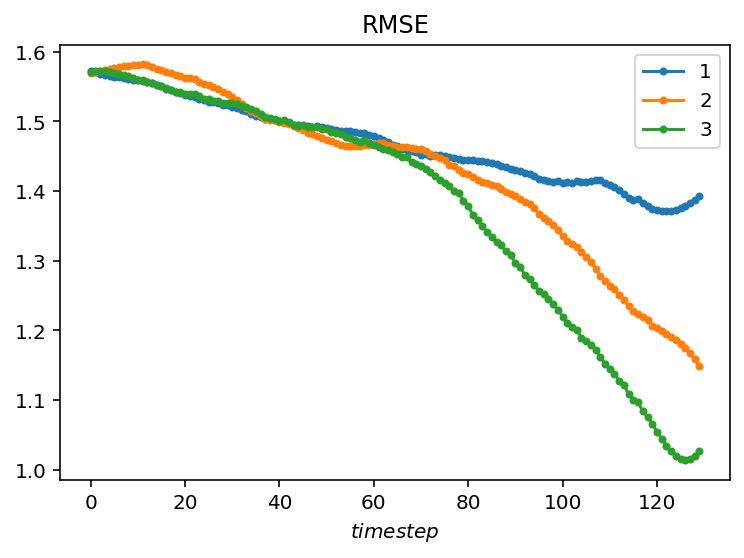

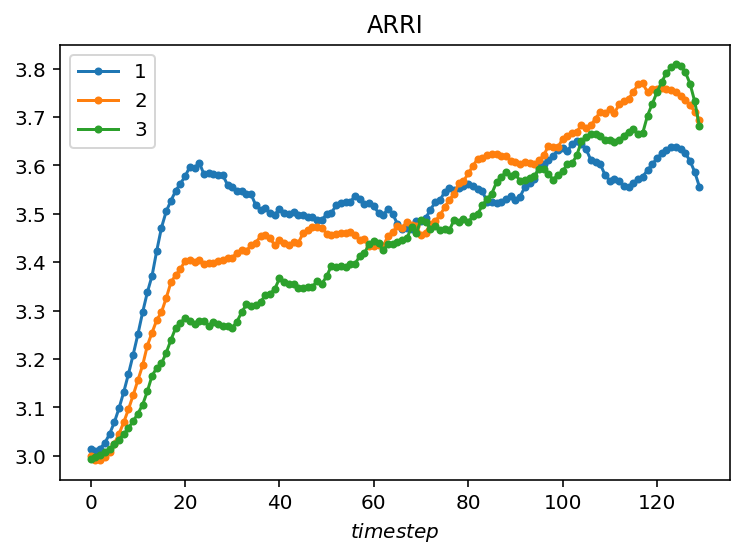

In [11]:
rmses = {
    0: [],
    0.15: [],
    0.3: []
}
arris = {
    0: [],
    0.15: [],
    0.3: []
}

REPEATS = 3
for epsilon in (0, 0.15, 0.3):
  recommender = LibFM_MLHB(type='eps_greedy',
                        eps=float(epsilon),
                        num_user_features=0,
                        num_item_features=0,
                        num_rating_features=0,
                        max_num_users=NUM_USERS,
                        max_num_items=NUM_ITEMS,
                        seed=0)
  
  for repeat in range(REPEATS):
    # run simulation
    print(f"epsilon={epsilon}, repeat={repeat}")
    losses, avg_ratings = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[RMSE, avg_rec_rating], reset=True, seed=repeat)
    rmses[epsilon].append(losses)
    arris[epsilon].append(avg_ratings)

mean_rmses = {
    0: [],
    0.15: [],
    0.3: []
}
mean_arris = {
    0: [],
    0.15: [],
    0.3: []
}
for epsilon in (0, 0.15, 0.3):
  mean_rmses[epsilon] = list(np.mean(np.asarray(rmses[epsilon]), axis=0))
  mean_arris[epsilon] = list(np.mean(np.asarray(arris[epsilon]), axis=0))

mean_rmses_vals = list(mean_rmses.values())
mean_arris_vals = list(mean_arris.values()) 
plot_graphs(*mean_rmses_vals, title="RMSE")
plot_graphs(*mean_arris_vals, title="ARRI")

### 1.2.2 Results
Explain your results here.

**Answer**: In the use-case, the dynamics of the environment change over time, thus continuous exploration results in the best performance. Models that are not exploring enough rely on past data that is quickly becoming irrelevant. In practice, the "value" of exploration is higher in a changing environment, when the distribution of user preferences changes in time. 

## 1.3 Supplier churn

In this section we will directly model supplier behavior.
Like in HW4, each supplier $i$ owns all items of topic $i$,
and profits whenever the system recommends items from this topic.
In this section, we will explore the effects of *supplier churn*,
which happens when unhappy suppliers decide to permanently leave the recommendation environment.

In our environment, there are $K$ suppliers, all of which start out with an initial amount of $30/K$ **tolerance points**. At each timestep, each supplier $i$:
* gains $2p_i$ points, and
* loses $1/K$ points

where $p_i$ is the fraction of items of topic $i$ that was recommended to online users.
Churn happens if at any point in time a supplier reaches $0$ tolarence points; if this occurs, the supplier immediatly leaves the environment, meaning that users will no longer be recommended items corresponding to that supplier's topic.

An additional change in this environment is that a certain fraction $F$ of the users are **biased**:
* Non-biased users' preference for topics are drawn from a uniform distibution.
* Biased users prefer topics with larger indices: for two topics $i,j$ with $i>j$, the user has higher preference for $i$ than for $j$.

**No need to read and understand the following codeblocks.**

In [12]:
def remove_topics_from_recommender(env, recommender, topics_list):
  if not hasattr(recommender, 'excluded_topics'):
    recommender.excluded_topics = []
    
  topics_list = np.setdiff1d(topics_list, excluded_topics(recommender))
  recommender.excluded_topics = np.concatenate((recommender.excluded_topics, topics_list))

  if recommender._exclude is None:
    recommender._exclude = []

  excluded_items = []
  for topic in topics_list:
    topic_items = np.where(env._item_topics == topic)[0]
    excluded_items = np.concatenate((excluded_items, topic_items))

  for item in excluded_items:
    recommender._exclude += [(user_id, item) for user_id in range(env._num_users)]
  
  recommender.update()

def excluded_topics(recommender):
  if hasattr(recommender, 'excluded_topics'):
    return recommender.excluded_topics
  return []

In [13]:
def remove_topics_for_neglected_suppliers(env, recommender):
  assert hasattr(env, 'suppliers_points')

  online_users = env.online_users
  recommendations, _ = recommender.recommend(online_users, 1)
  true_ratings = env.dense_ratings
  # add points
  topics_histogram = np.zeros(env._num_topics, dtype=np.float64)
  for user, item in zip(list(online_users.keys()), np.array(recommendations).flatten()):
    topic = env._item_topics[item]
    topics_histogram[topic] += 1
  topics_histogram /= len(recommendations)
  env.suppliers_points += 2*topics_histogram
  
  env.suppliers_points -= 1/(env._num_topics-len(excluded_topics(recommender)))
  topics_to_exclude = np.where(env.suppliers_points < 0)[0]
  env.suppliers_points[topics_to_exclude] = 0
  remove_topics_from_recommender(env, recommender, topics_to_exclude)
  return np.copy(env.suppliers_points)

In [14]:
# has to be called after env.reset()
def initialize_ratings(env, initial_points, biased_users_frac):
  np.random.seed(0)
  env.biased_users_frac = biased_users_frac
  env.suppliers_points = np.full(env._num_topics, initial_points, dtype=np.float64)
  num_biased_users = int(biased_users_frac*env._num_users)
  preferences = np.arange(0.5, 5.5, 5./env._num_topics)
  env._user_preferences[:num_biased_users] = np.repeat(preferences.reshape((1, env._num_topics)), repeats=num_biased_users, axis=0)

In [15]:
def avg_rec_rating_split(env, recommender, biased_users=True):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  num_biased_users = int(env.biased_users_frac*env._num_users)
  recommendations = recommendations[:num_biased_users] if biased_users else recommendations[num_biased_users:]
  true_ratings = env.dense_ratings
  sum = 0
  for i, item in enumerate(recommendations):
    user = i
    if not biased_users:
      user += num_biased_users
    sum += true_ratings[user, item[0]]
  return sum/(len(recommendations))

### 1.3.1 Low bias population simulation
Run the following code block which runs epsilon-greedy simulations for $F = 0.1$ and $\epsilon \in \{0, 0.15, 0.3\}$.
(No need to modify the code in any way.)

The code plots the lossed graph and the average ratings for each population (biased/non-biased users) seperately for each $\varepsilon$ on the same plot. It also plots the tolarence points of the suppliers for each simulation separately, and prints how many suppliers remained at the end.

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


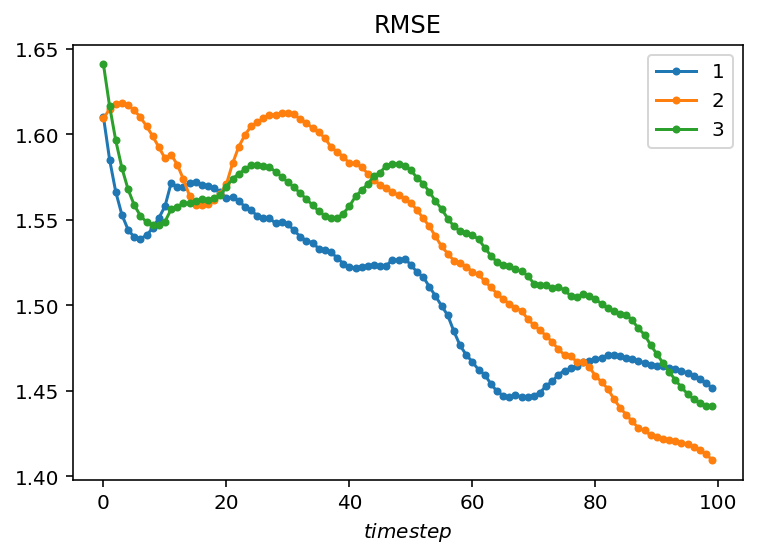

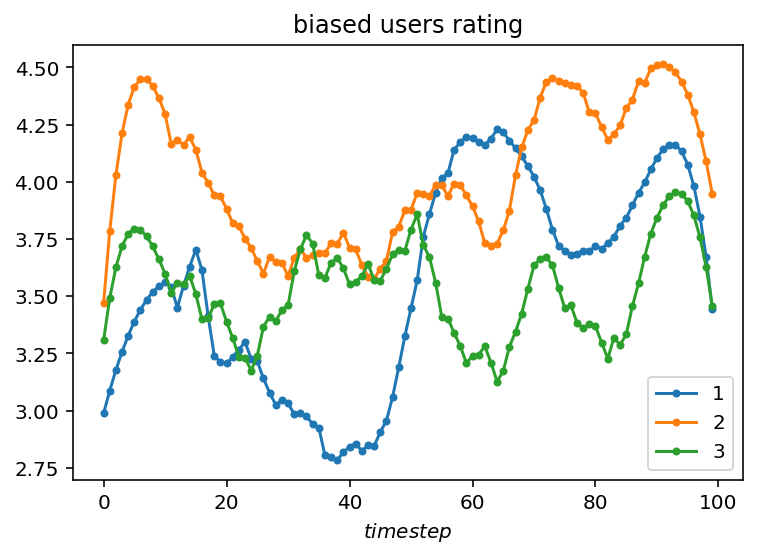

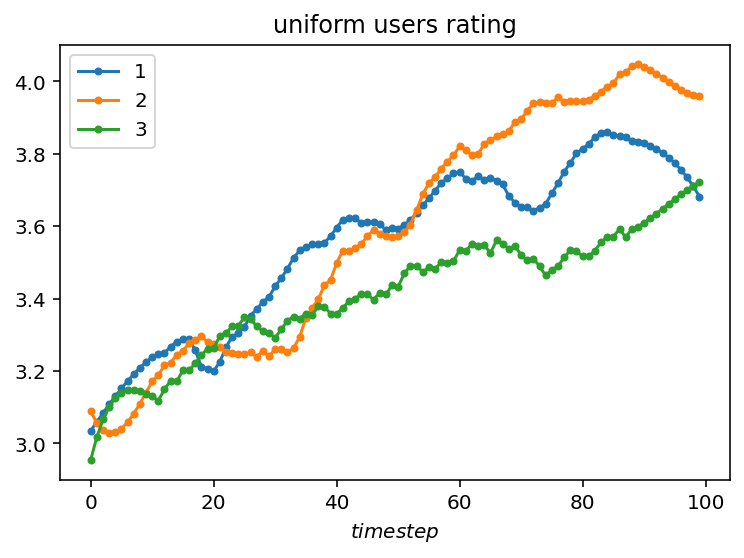

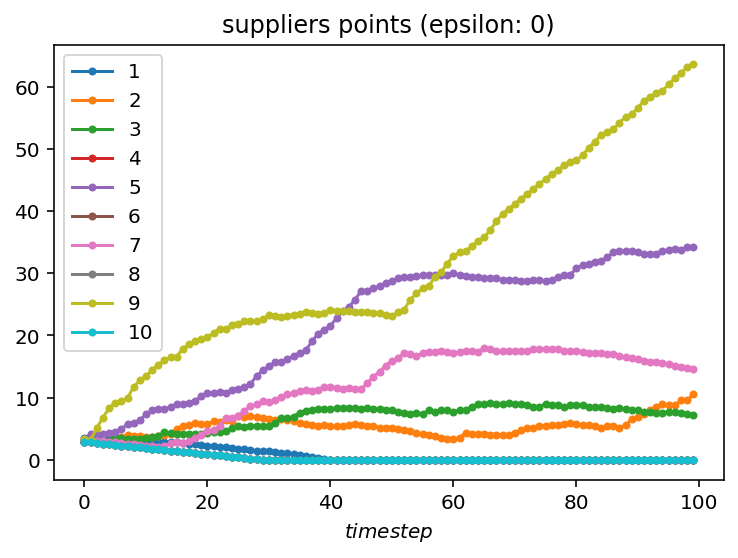

Remaining suppliers: 5


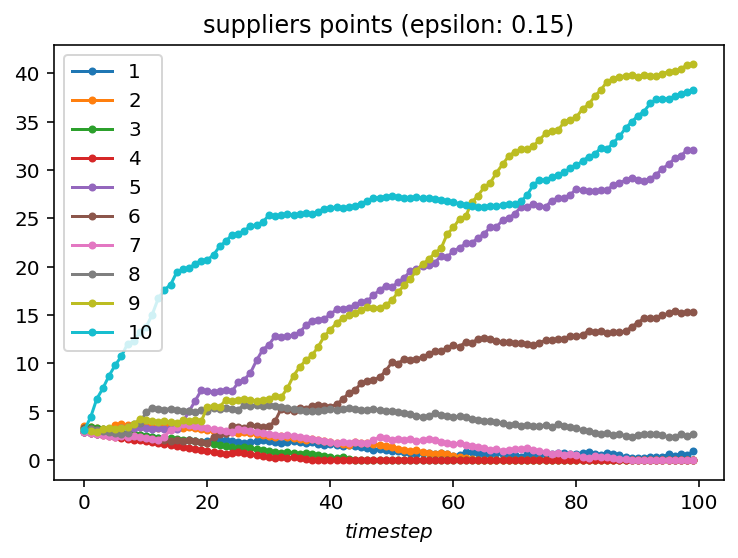

Remaining suppliers: 6


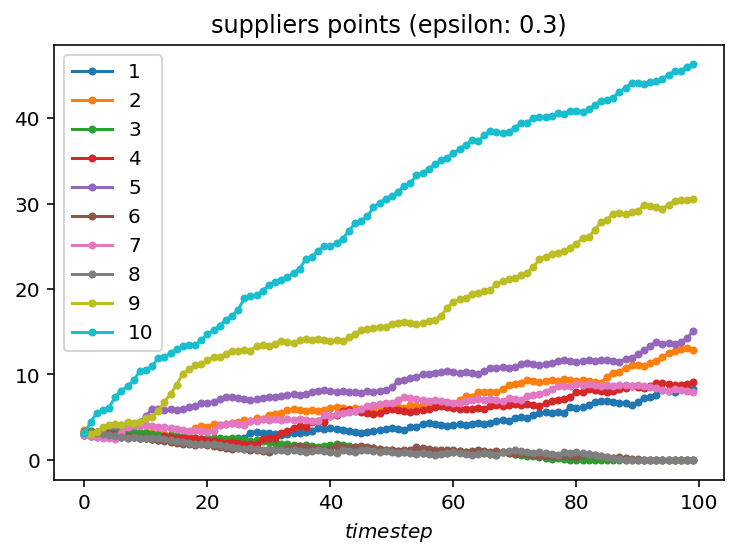

Remaining suppliers: 7


In [16]:
NUM_USERS = 100
NUM_ITEMS = 100
NUM_TOPICS = 10
BIASED_USERS_FRAC = 0.1
INIT_POINTS = 30./NUM_TOPICS
STEPS = 100

env_params = {"num_topics": NUM_TOPICS,
              "num_users": NUM_USERS,
              "num_items": NUM_ITEMS,
              "rating_frequency": 0.1,
              "num_init_ratings": 1,
              "topic_change": 0}

epsilon_values = [0, 0.15, 0.3]

all_losses = []
all_avg_ratings_biased = []
all_avg_ratings_uni = []
all_suppliers_points = []
for epsilon in epsilon_values:

  env = Topics(**env_params)
  env.seed(0)
  items, users, ratings = env.reset()
  initialize_ratings(env, INIT_POINTS, BIASED_USERS_FRAC)

  recommender = LibFM_MLHB(type='eps_greedy',
                      eps=float(epsilon),
                      num_user_features=0,
                      num_item_features=0,
                      num_rating_features=0,
                      max_num_users=NUM_USERS,
                      max_num_items=NUM_ITEMS,
                      seed=0)
  recommender.reset(items, users, ratings)
  
  losses, avg_ratings_biased, avg_ratings_uni, suppliers_points = simulation(env, recommender, steps=STEPS, retrain=True,
                                                        callbacks=[RMSE, lambda e, r: avg_rec_rating_split(e, r, True),
                                                                   lambda e, r: avg_rec_rating_split(e, r, False),
                                                                   remove_topics_for_neglected_suppliers], reset=False)
  all_losses.append(losses)
  all_avg_ratings_biased.append(avg_ratings_biased)
  all_avg_ratings_uni.append(avg_ratings_uni)
  all_suppliers_points.append(suppliers_points)

plot_graphs(*all_losses, title='RMSE')
plot_graphs(*all_avg_ratings_biased, title="biased users rating")
plot_graphs(*all_avg_ratings_uni, title="uniform users rating")

for i, epsilon in enumerate(epsilon_values):
  plot_graphs(*((np.array(all_suppliers_points[i]).T).tolist()), title='suppliers points (epsilon: ' + str(epsilon) + ')', smooth=False)
  print("Remaining suppliers: " + str(np.sum(np.all(np.array(all_suppliers_points[i]), axis=0))))

### 1.3.2 Results
Explain your results here.

**Answer**: concerning suppliers- The more exploration we take, the more suppliers remain over time. This is because we explore and recommend topics of all suppliers, not making them leave the environment. When models always exploit, only certain topics are recommended, and un-recommended suppliers leave. In terms of predictive error and average rating, we still observe that taking the midpoint between zero exploration and too much exploration is optimal.

### 1.3.3 High bias population simulation
Run an epsilon-greedy simulation for $F = 0.9$ and for $\epsilon \in \{0, 0.15, 0.3\}$.
Plot the same statistic data and graphs as the previous section (losses, avg ranking for each population separately, supplier points, remaining suppliers).
The variable in the previous codeblock corresponding to the biased population fraction $F$ is ```BIASED_USERS_FRAC```.

100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


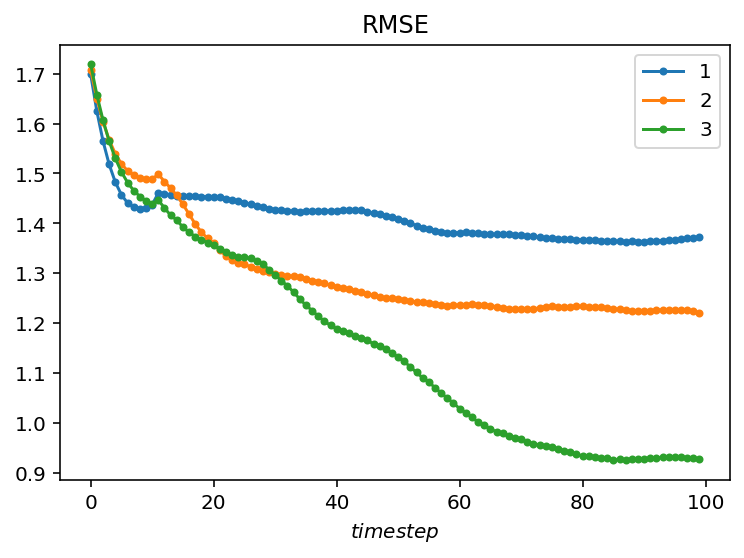

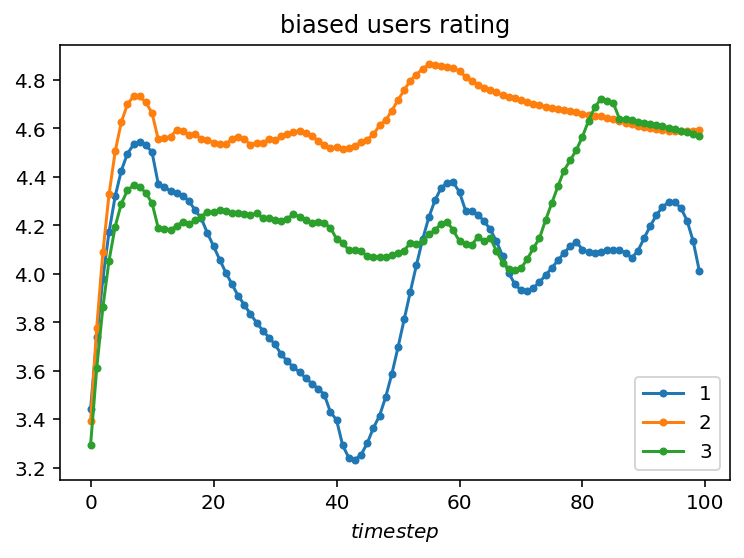

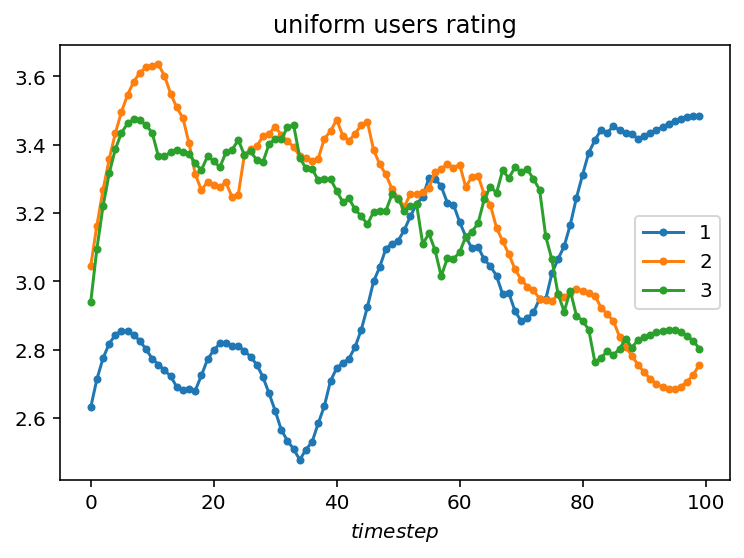

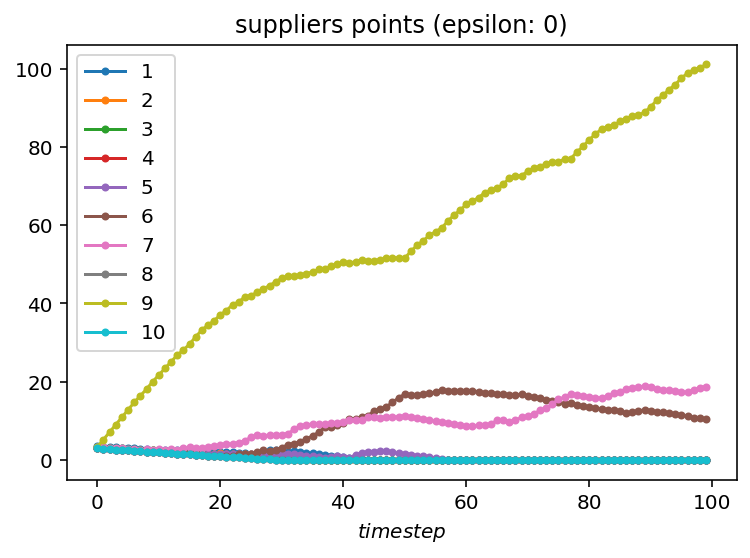

Remaining suppliers: 3


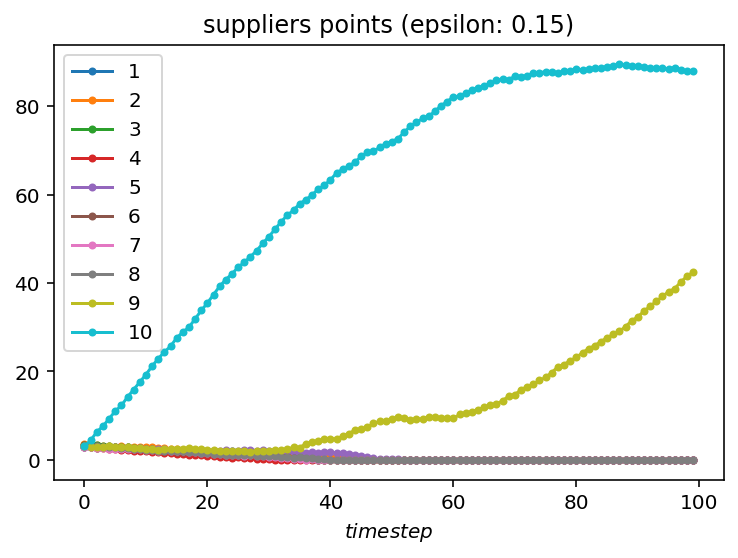

Remaining suppliers: 2


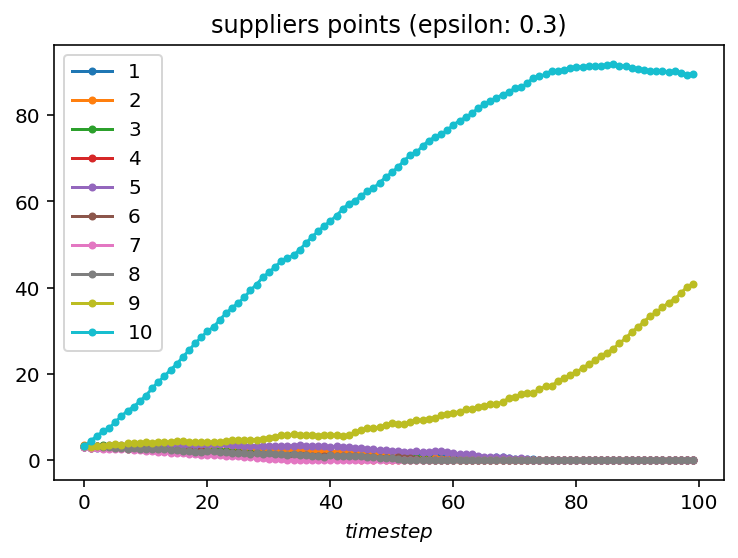

Remaining suppliers: 2


In [17]:
NUM_USERS = 100
NUM_ITEMS = 100
NUM_TOPICS = 10
BIASED_USERS_FRAC = 0.9
INIT_POINTS = 30./NUM_TOPICS
STEPS = 100

env_params = {"num_topics": NUM_TOPICS,
              "num_users": NUM_USERS,
              "num_items": NUM_ITEMS,
              "rating_frequency": 0.1,
              "num_init_ratings": 1,
              "topic_change": 0}

epsilon_values = [0, 0.15, 0.3]

all_losses = []
all_avg_ratings_biased = []
all_avg_ratings_uni = []
all_suppliers_points = []
for epsilon in epsilon_values:

  env = Topics(**env_params)
  env.seed(0)
  items, users, ratings = env.reset()
  initialize_ratings(env, INIT_POINTS, BIASED_USERS_FRAC)

  recommender = LibFM_MLHB(type='eps_greedy',
                      eps=float(epsilon),
                      num_user_features=0,
                      num_item_features=0,
                      num_rating_features=0,
                      max_num_users=NUM_USERS,
                      max_num_items=NUM_ITEMS,
                      seed=0)
  recommender.reset(items, users, ratings)
  
  losses, avg_ratings_biased, avg_ratings_uni, suppliers_points = simulation(env, recommender, steps=STEPS, retrain=True,
                                                        callbacks=[RMSE, lambda e, r: avg_rec_rating_split(e, r, True),
                                                                   lambda e, r: avg_rec_rating_split(e, r, False),
                                                                   remove_topics_for_neglected_suppliers], reset=False)
  all_losses.append(losses)
  all_avg_ratings_biased.append(avg_ratings_biased)
  all_avg_ratings_uni.append(avg_ratings_uni)
  all_suppliers_points.append(suppliers_points)

plot_graphs(*all_losses, title='RMSE')
plot_graphs(*all_avg_ratings_biased, title="biased users rating")
plot_graphs(*all_avg_ratings_uni, title="uniform users rating")

for i, epsilon in enumerate(epsilon_values):
  plot_graphs(*((np.array(all_suppliers_points[i]).T).tolist()), title='suppliers points (epsilon: ' + str(epsilon) + ')', smooth=False)
  print("Remaining suppliers: " + str(np.sum(np.all(np.array(all_suppliers_points[i]), axis=0))))

### 1.3.4 Results
Explain your results here. In your answer address the differences from previous section (with los bias population fraction).

**Answer**: In this use-case, users tend to prefer topics with high indices (90% biased users). Hence, we see that in general, more suppliers leave since their topics are less get picked and less recommended. Specifically, when we explore, the topics with the highest indices (9, 10) are skyrocketing, since we expose users to their topics. When we do not explore at all (epsilon=), the recommendation to user high topics is random, and then the recommended might not get exposes to high indices topics ratings (from users). This is why for epsilon=0 supplier number 10 left early, while supplier 9 that was exposed has succeeded. 

# Part 2: Strategic behaviour
We now turn to exploring what happens when suppliers are *strategic*.
For our purposes, a strategic player takes explicit actions to improve her outcomes.
In this part we will use the ```LatentFactorBehavior_MLHB``` environment.

## 2.1 Supplier strategic behaviour
Consider a recommendation environment in which each item belongs to a different supplier. Suppliers want consumers to like their product and rate them highly.

**No need to read and understand the following codeblocks.**

In [18]:
from sklearn.datasets import make_blobs

def plot_items(env, recommender):
  item_features = np.c_[env._item_factors, env._item_biases]
  assert item_features.shape[1] == 2

  plt.scatter(item_features[:, 0], item_features[:, 1])
  plt.show()

def recs_stds(env, recommender):
  item_features = np.c_[env._item_factors, env._item_biases]
  all_users = env.users
  stds = [0]
  for history in env._user_histories.values():
    if len(history) < 2:
      continue
    history_features = item_features[np.array(history).flatten()]
    std = np.mean(np.std(history_features, axis=0))
    stds.append(std)
  return np.mean(stds)
    
def knn(xTrain, xTest, k):
    """
    Finds the k nearest neighbors of xTest in xTrain.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    dists = distances between xTrain/xTest points. Size of n x m
    indices = kxm matrix with indices of yTrain labels
    """
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    distances[distances < 0] = 0
    indices = np.argsort(distances, 0) #get indices of sorted items
    return indices[0:k, : ]

def modify_items(env, recommender, m, alpha):

  item_features = np.c_[env._item_factors, env._item_biases]
  closest_neighbors = knn(item_features, item_features, m).T

  ratings = env.dense_ratings
  avg_rating_per_item = np.mean(ratings, axis=0)

  closest_neighbors_ratings = avg_rating_per_item[closest_neighbors]

  highest_rated_items = np.argmax(closest_neighbors_ratings, axis=1)
  indices = closest_neighbors[np.arange(env._num_items), highest_rated_items]

  env._item_factors -= alpha*(env._item_factors - env._item_factors[indices])
  env._item_biases -= alpha*(env._item_biases - env._item_biases[indices])

# has to be called after env.reset()
def create_clusters(env, num_clusters, cluster_std):
  np.random.seed(0)
  factor_sd = np.sqrt(np.sqrt(0.5 / env._latent_dim))
  centers_factors = factor_sd*np.random.randn(num_clusters, env._latent_dim)
  centers_biases = 0.5*np.random.randn(num_clusters)
  centers = np.c_[centers_factors, centers_biases]
  X, _ = make_blobs(n_samples=env._num_items, cluster_std=cluster_std, centers=centers, n_features=env._latent_dim + 1, random_state=0)
  env._item_factors = X[:, :-1]
  env._item_biases = X[:, -1]

### 2.1.1 Simulation
Run a simulation in which suppliers act strategically. No need to modify the code in any way. In addition to the all-too-familiar losses and average ratings graphs, here we will plot two additional metrics:

*   A scatter plot of the items' features (2 dimensional). This plot is generated after each timestep.
*   A line plot describing the standard deviation of each user's last $5$ recommended items features (averaged as each item has 2 features), averaged over all users, and as a function of time.

**Do not** look at the underlying code determining how suppliers act.

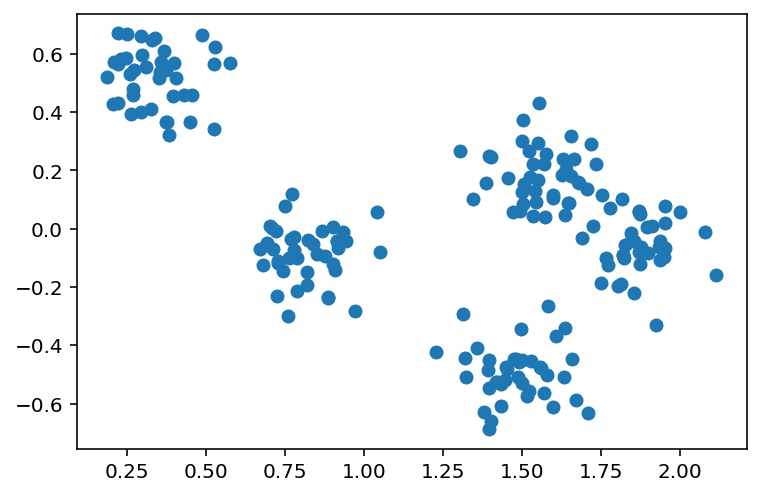

  0%|          | 0/100 [00:00<?, ?it/s]

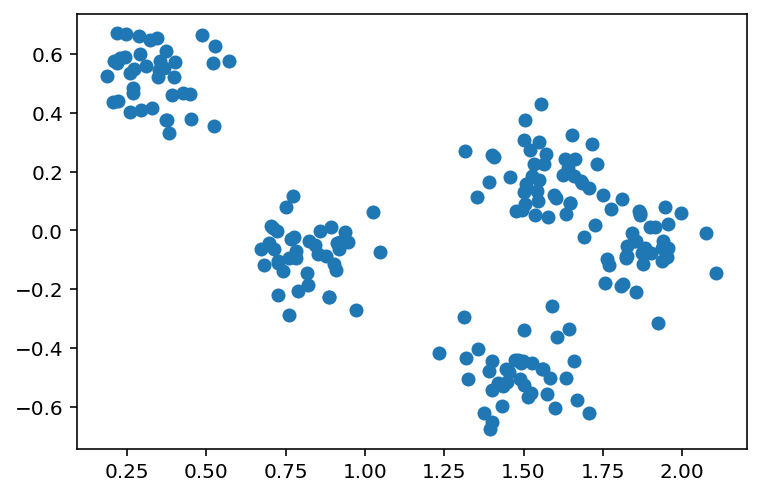

  1%|          | 1/100 [00:00<00:59,  1.65it/s]

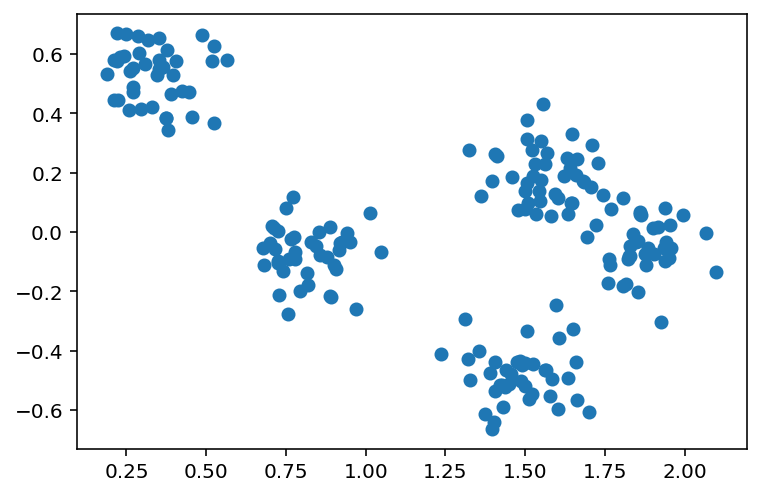

  2%|▏         | 2/100 [00:01<00:52,  1.88it/s]

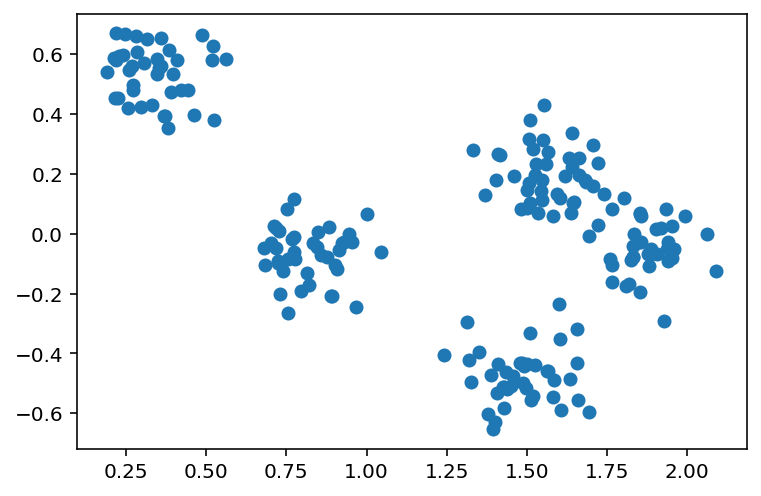

  3%|▎         | 3/100 [00:01<00:49,  1.97it/s]

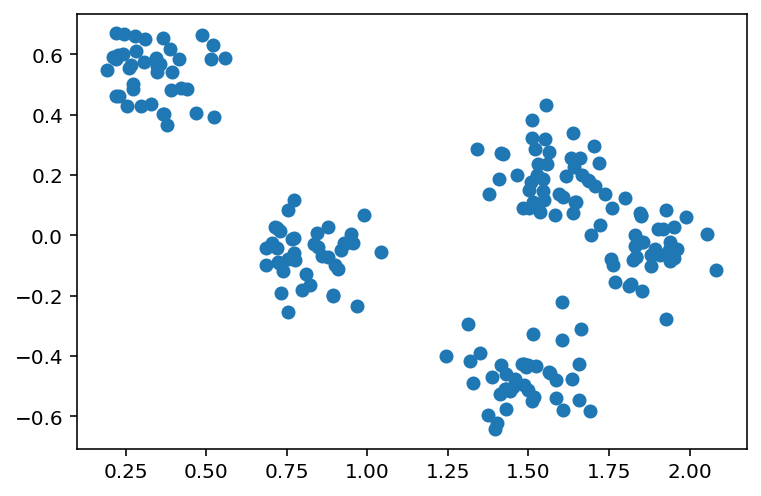

  4%|▍         | 4/100 [00:02<00:48,  1.99it/s]

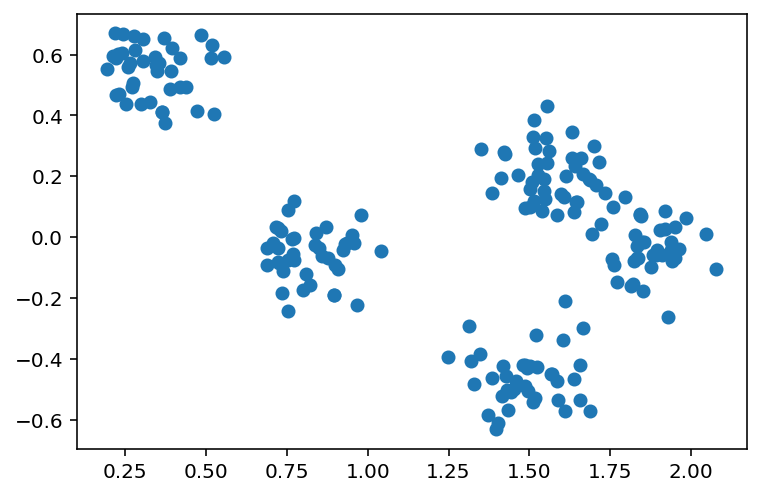

  5%|▌         | 5/100 [00:02<00:46,  2.03it/s]

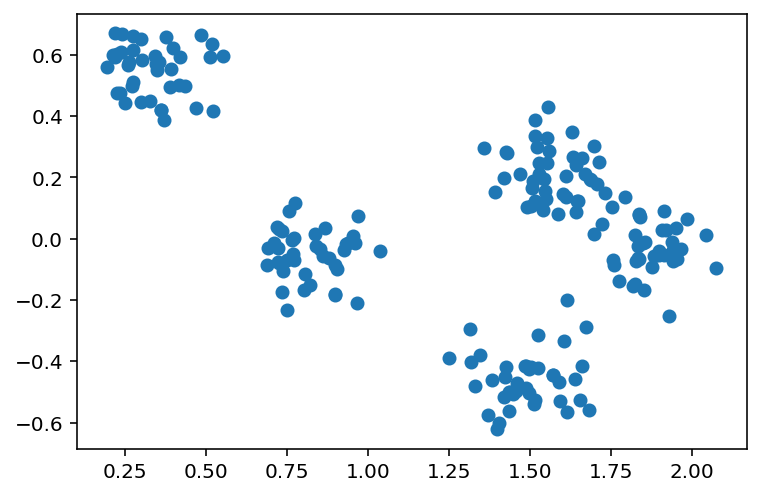

  6%|▌         | 6/100 [00:03<00:45,  2.05it/s]

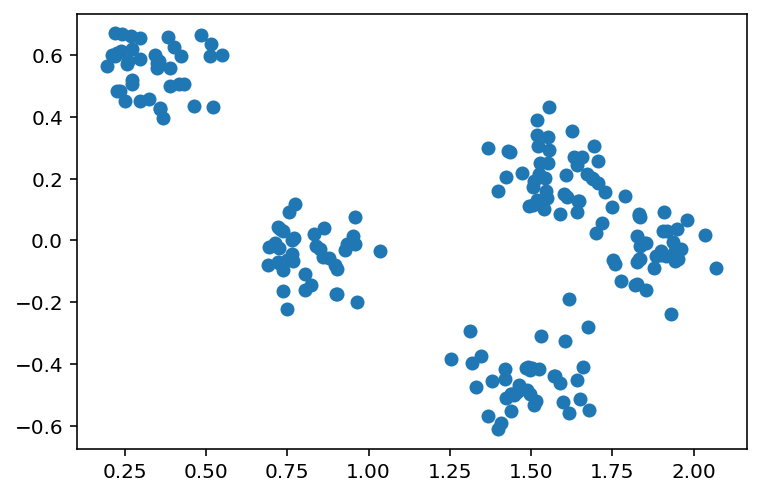

  7%|▋         | 7/100 [00:03<00:45,  2.05it/s]

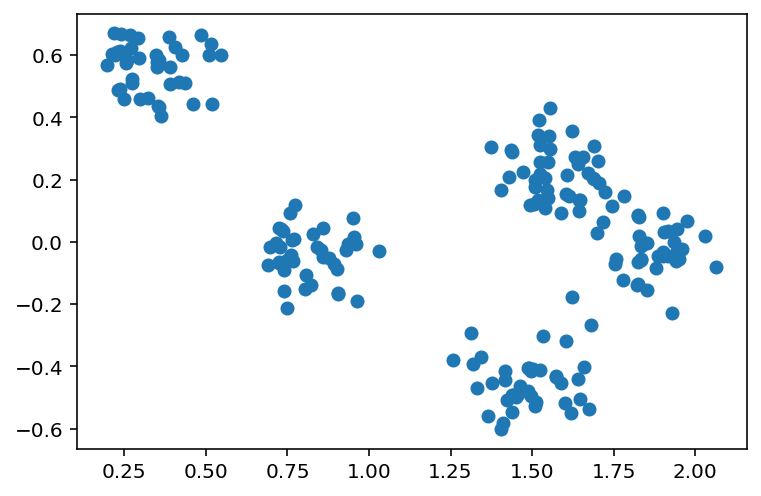

  8%|▊         | 8/100 [00:03<00:45,  2.04it/s]

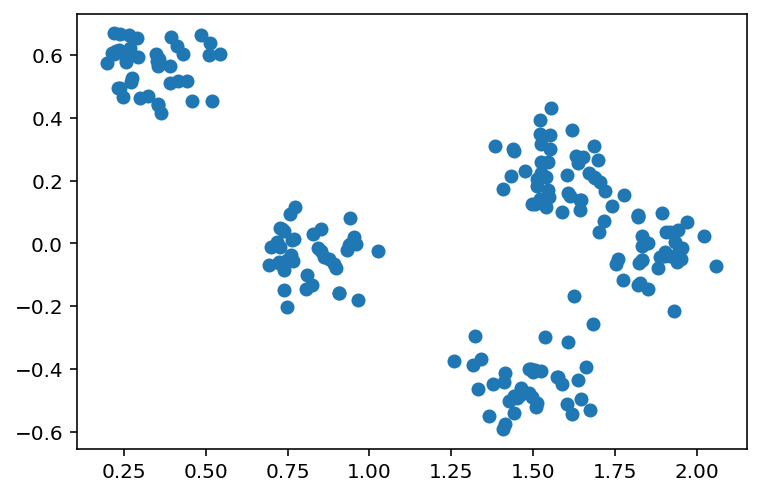

  9%|▉         | 9/100 [00:04<00:44,  2.04it/s]

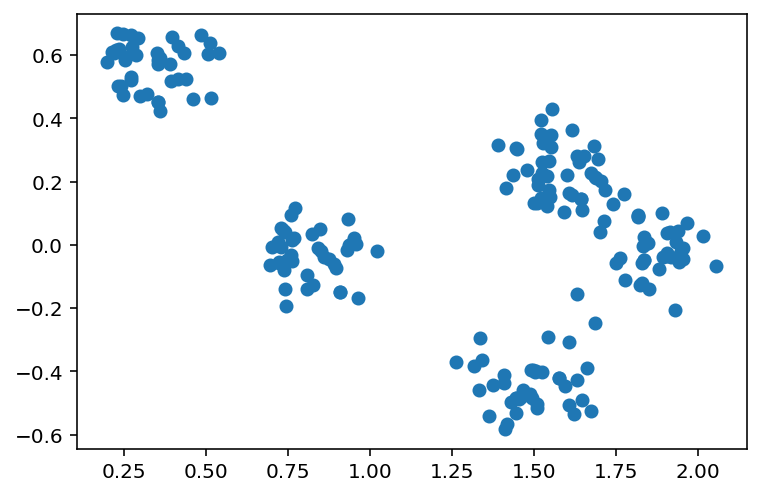

 10%|█         | 10/100 [00:05<00:44,  2.01it/s]

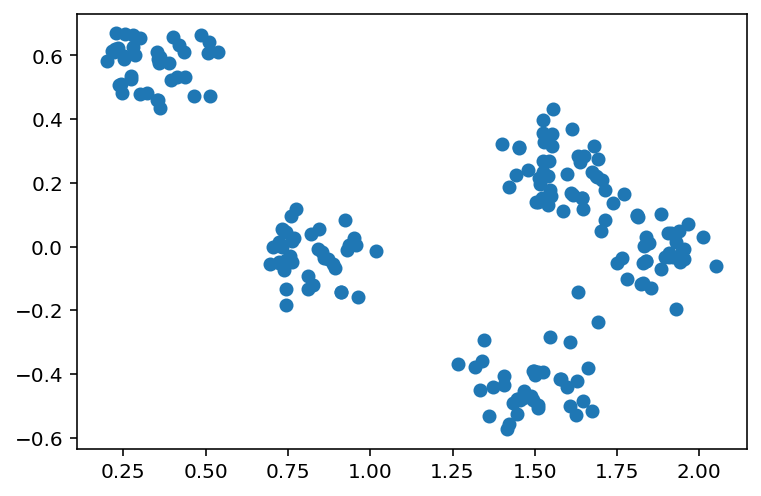

 11%|█         | 11/100 [00:05<00:44,  2.01it/s]

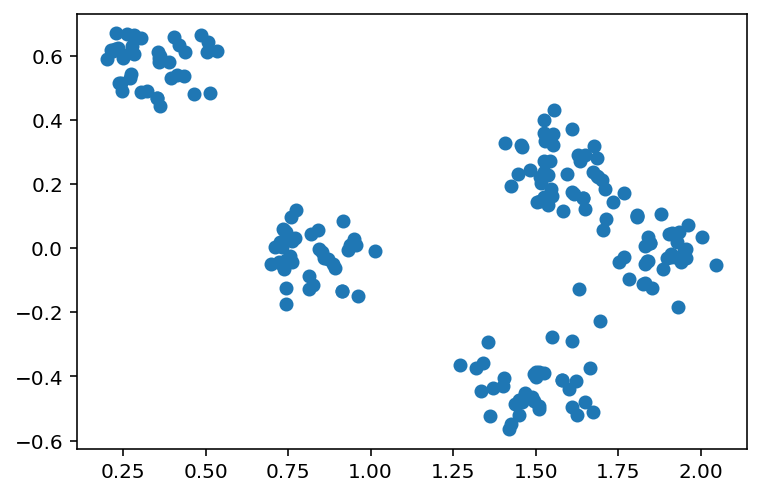

 12%|█▏        | 12/100 [00:06<00:44,  1.99it/s]

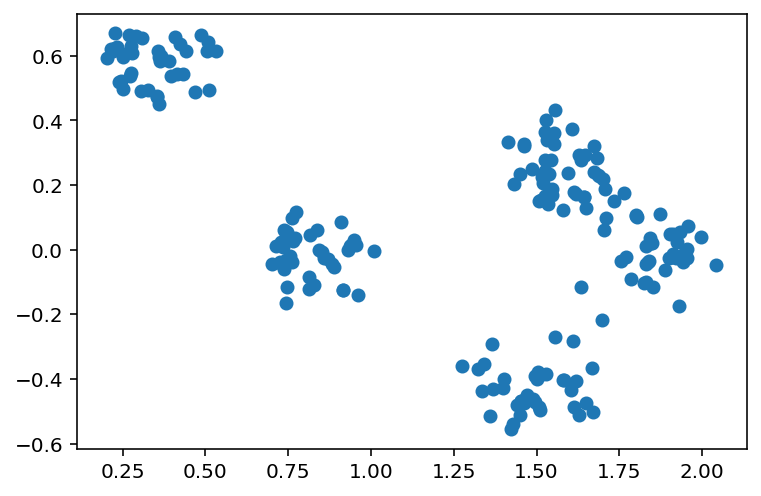

 13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]

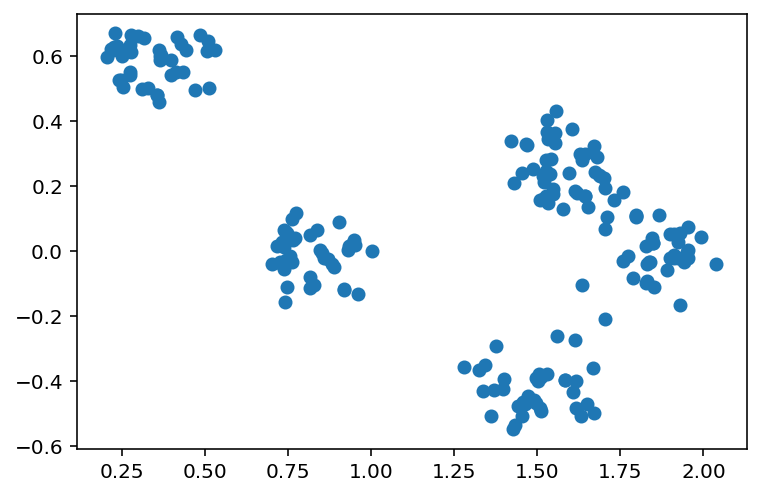

 14%|█▍        | 14/100 [00:07<00:43,  1.99it/s]

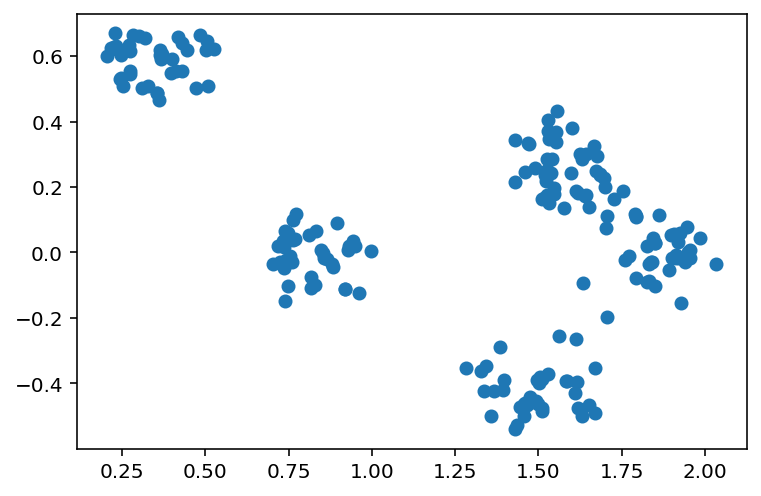

 15%|█▌        | 15/100 [00:07<00:42,  1.98it/s]

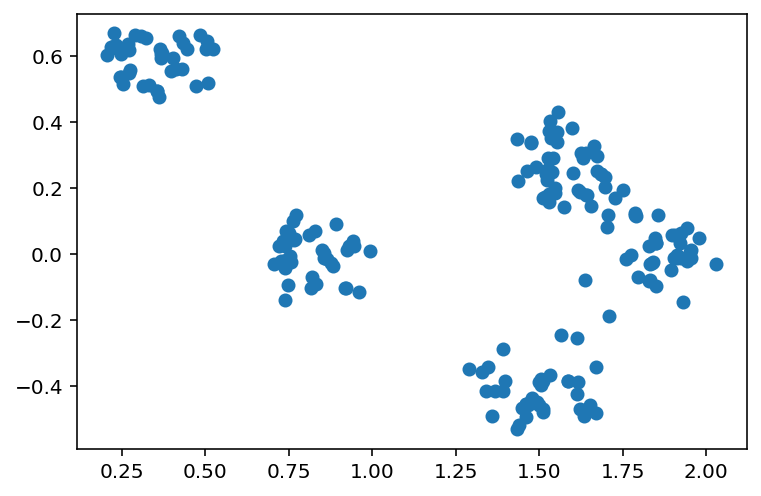

 16%|█▌        | 16/100 [00:08<00:42,  1.96it/s]

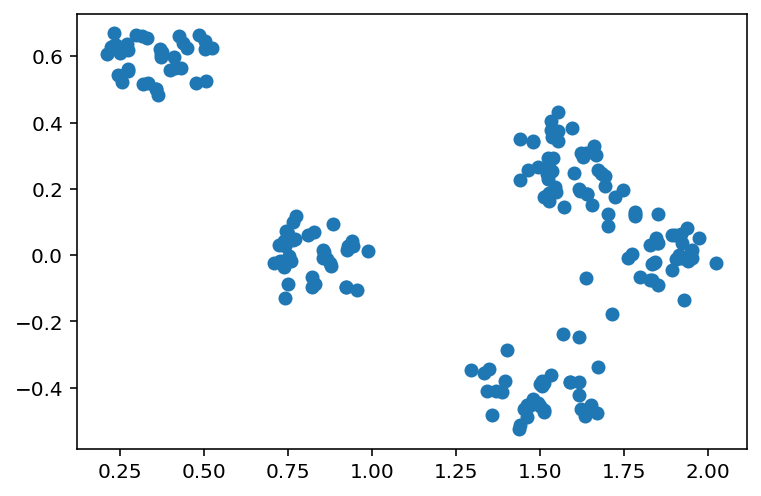

 17%|█▋        | 17/100 [00:08<00:42,  1.96it/s]

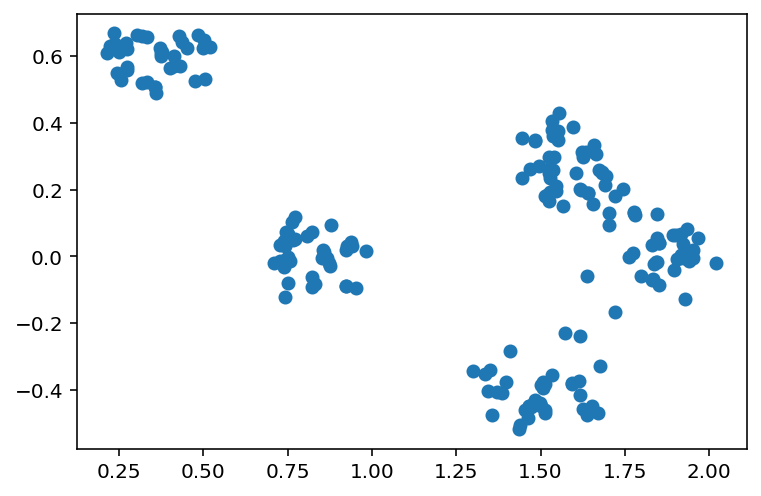

 18%|█▊        | 18/100 [00:09<00:42,  1.94it/s]

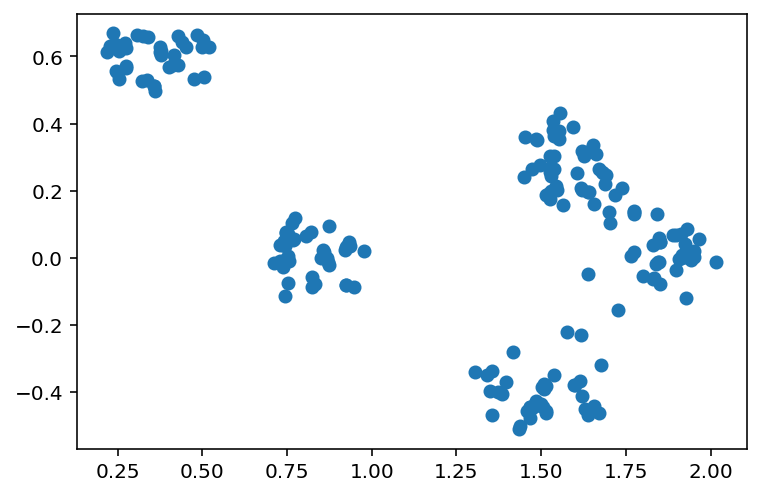

 19%|█▉        | 19/100 [00:09<00:41,  1.94it/s]

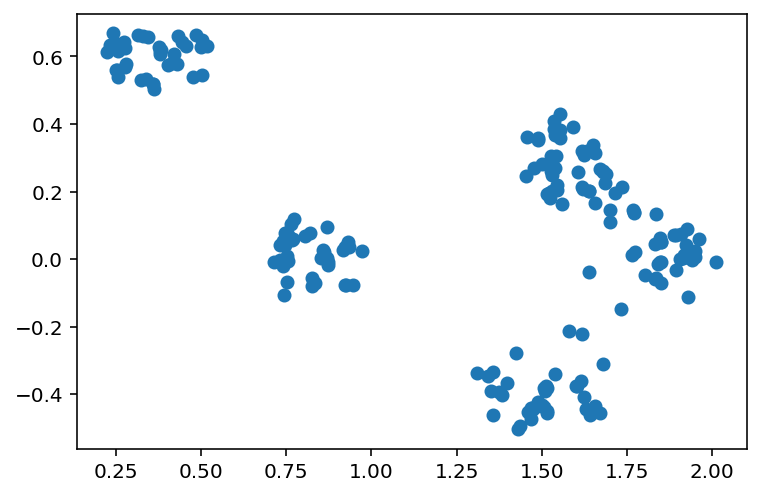

 20%|██        | 20/100 [00:10<00:41,  1.93it/s]

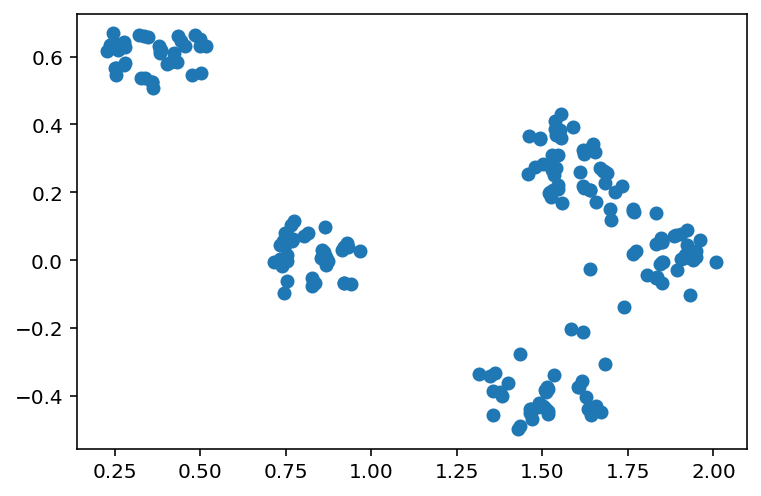

 21%|██        | 21/100 [00:10<00:41,  1.93it/s]

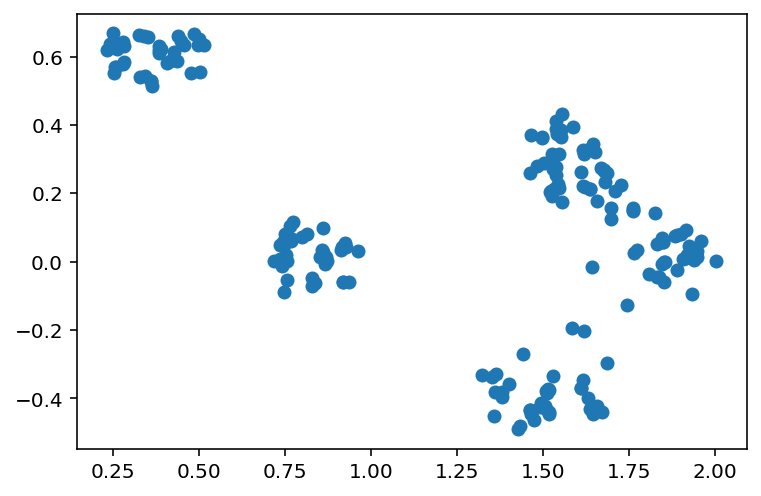

 22%|██▏       | 22/100 [00:11<00:40,  1.92it/s]

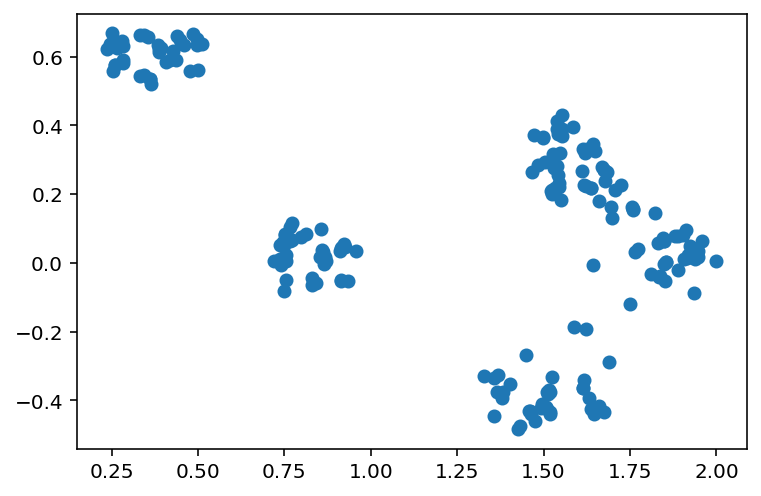

 23%|██▎       | 23/100 [00:11<00:40,  1.92it/s]

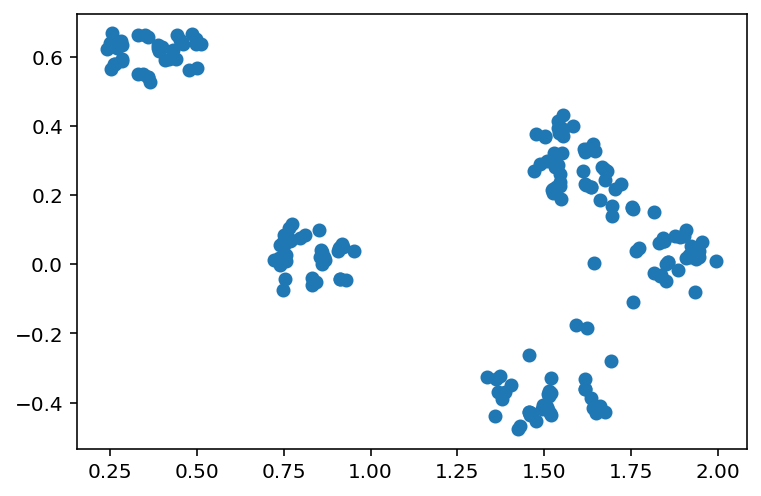

 24%|██▍       | 24/100 [00:12<00:39,  1.91it/s]

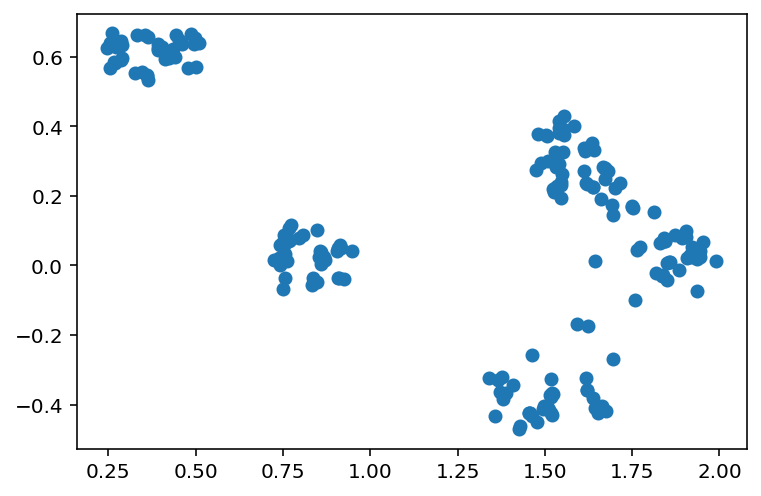

 25%|██▌       | 25/100 [00:12<00:39,  1.88it/s]

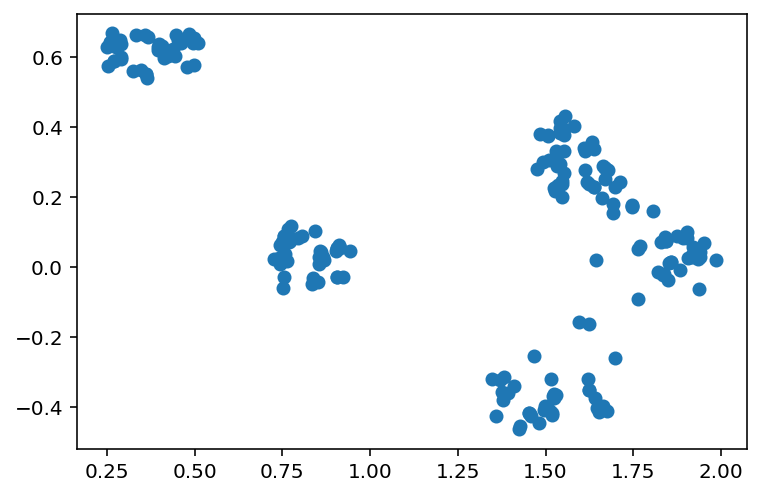

 26%|██▌       | 26/100 [00:13<00:39,  1.87it/s]

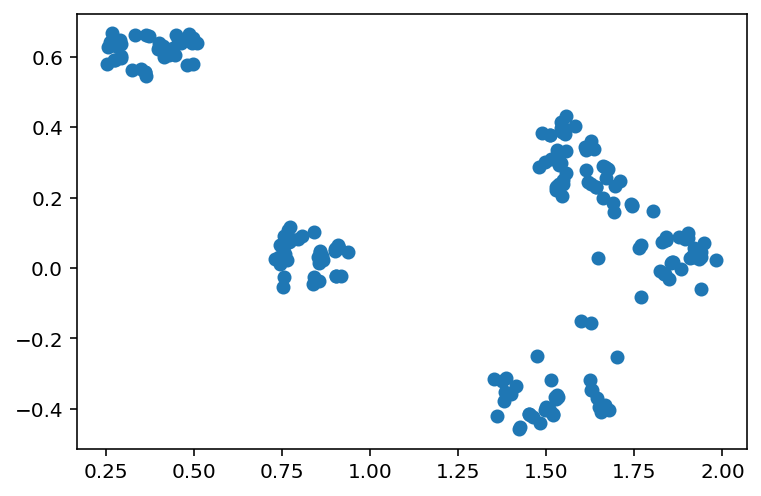

 27%|██▋       | 27/100 [00:13<00:39,  1.87it/s]

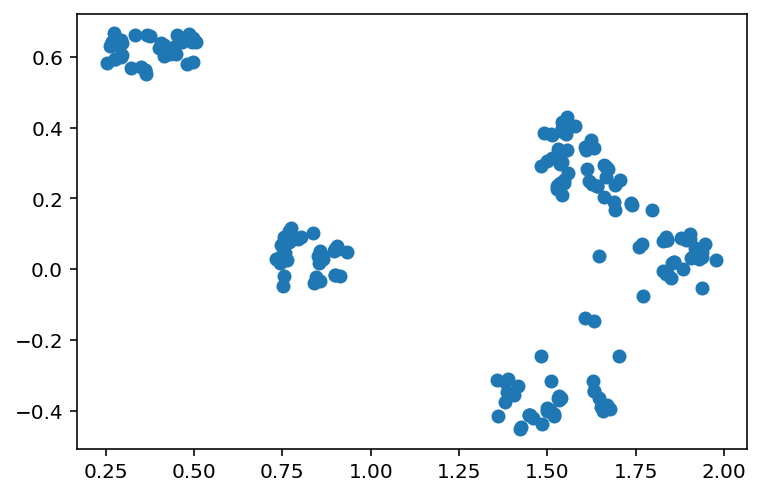

 28%|██▊       | 28/100 [00:14<00:38,  1.87it/s]

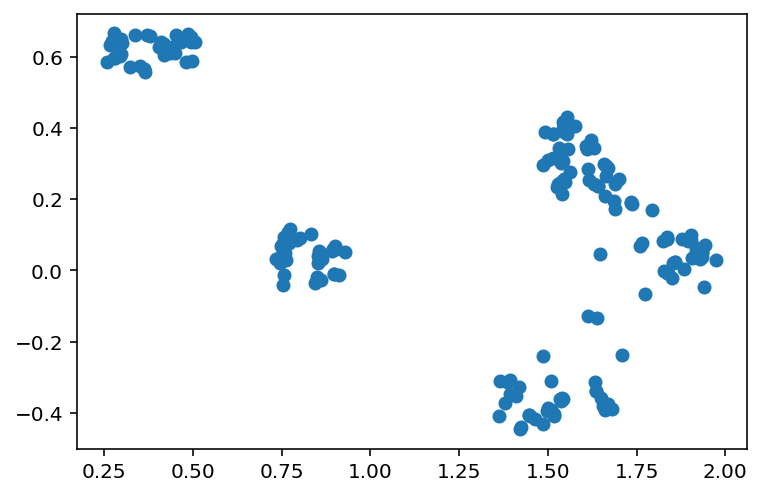

 29%|██▉       | 29/100 [00:14<00:37,  1.88it/s]

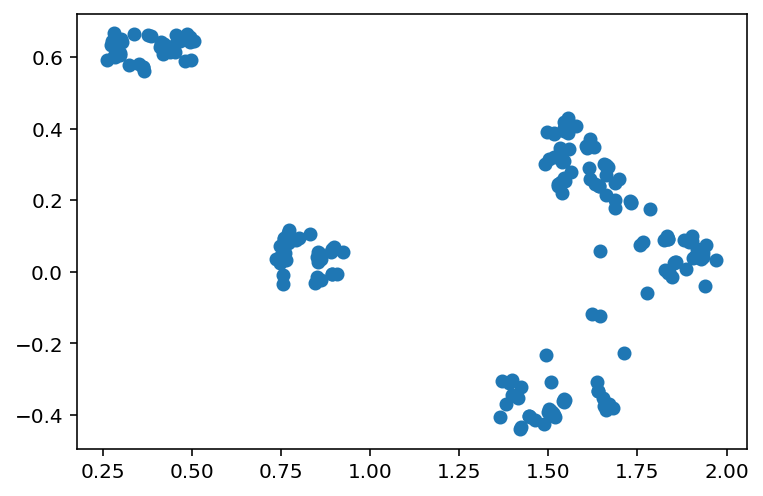

 30%|███       | 30/100 [00:15<00:41,  1.70it/s]

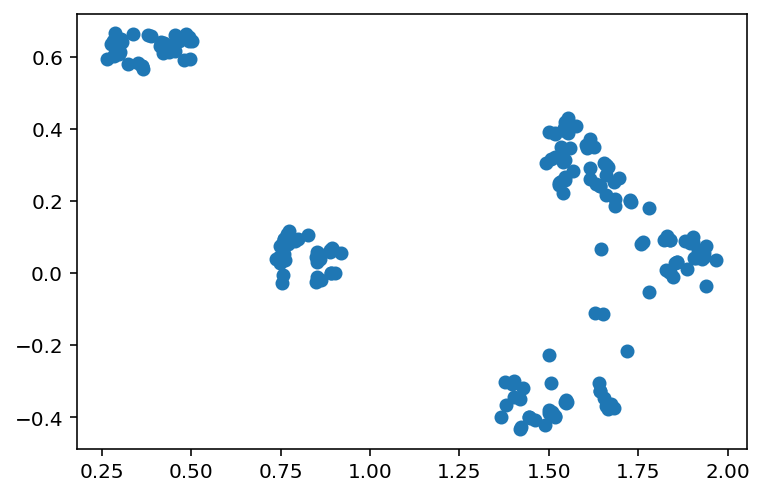

 31%|███       | 31/100 [00:16<00:39,  1.73it/s]

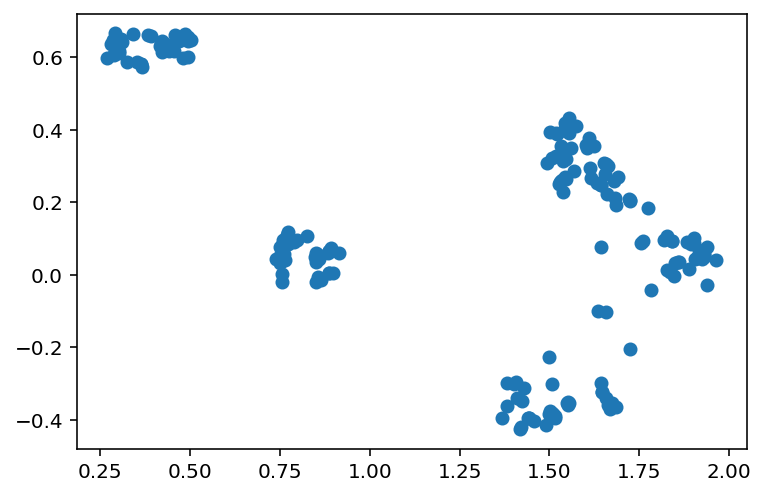

 32%|███▏      | 32/100 [00:16<00:38,  1.76it/s]

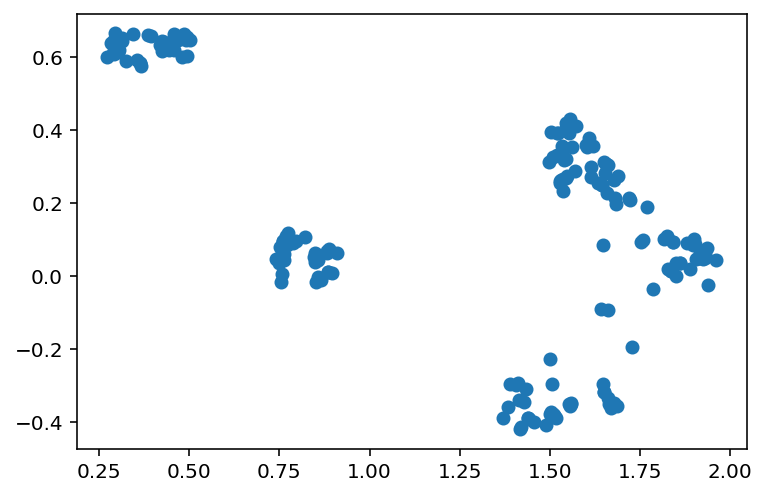

 33%|███▎      | 33/100 [00:17<00:37,  1.78it/s]

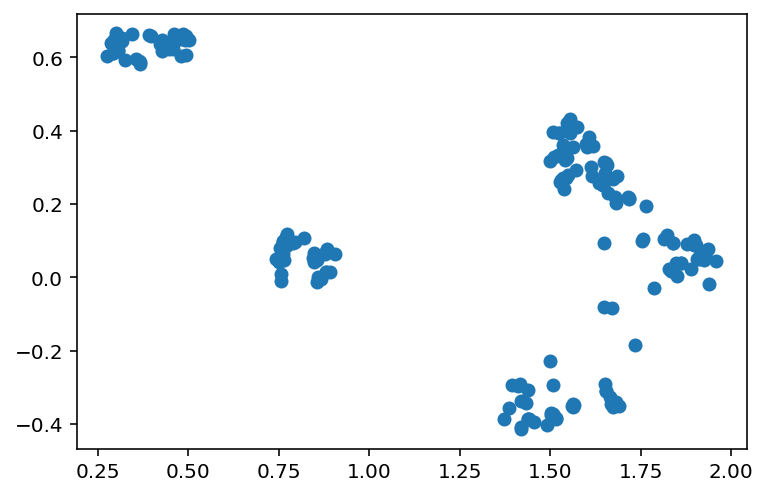

 34%|███▍      | 34/100 [00:17<00:36,  1.79it/s]

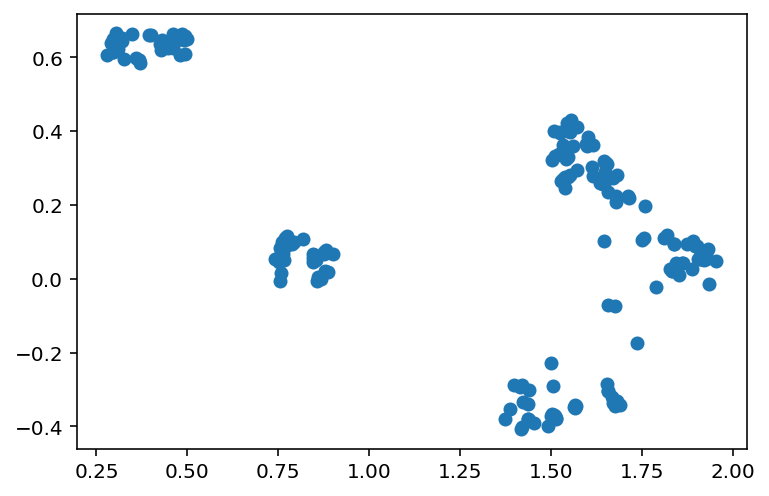

 35%|███▌      | 35/100 [00:18<00:36,  1.80it/s]

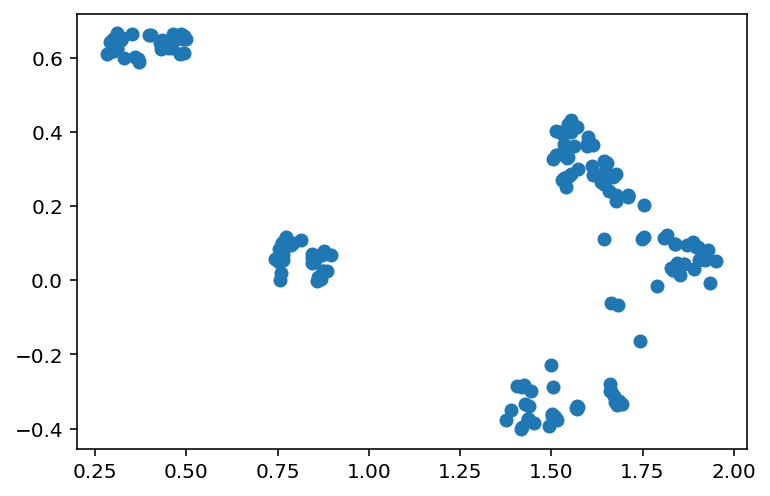

 36%|███▌      | 36/100 [00:18<00:35,  1.81it/s]

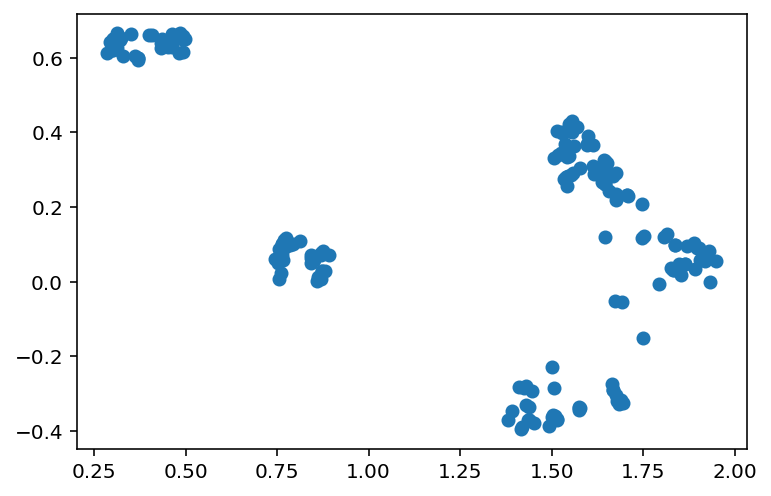

 37%|███▋      | 37/100 [00:19<00:34,  1.81it/s]

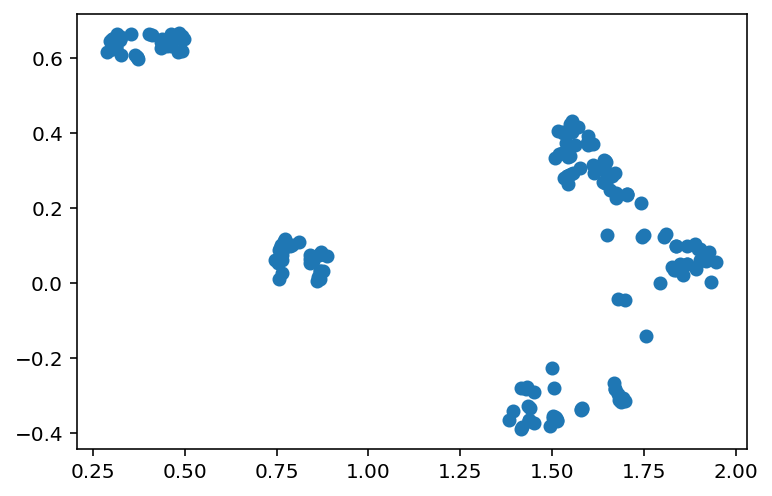

 38%|███▊      | 38/100 [00:20<00:34,  1.82it/s]

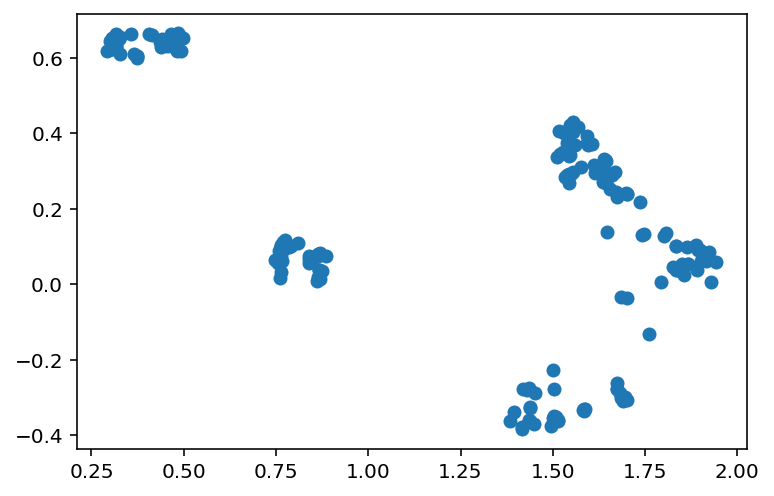

 39%|███▉      | 39/100 [00:20<00:33,  1.80it/s]

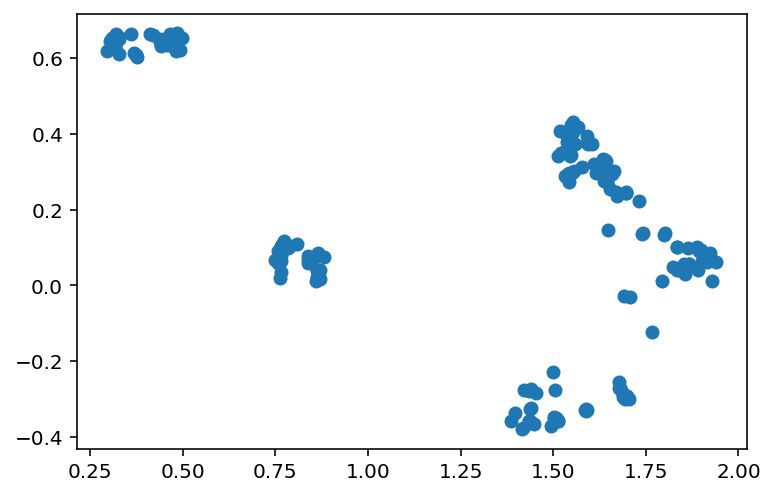

 40%|████      | 40/100 [00:21<00:33,  1.80it/s]

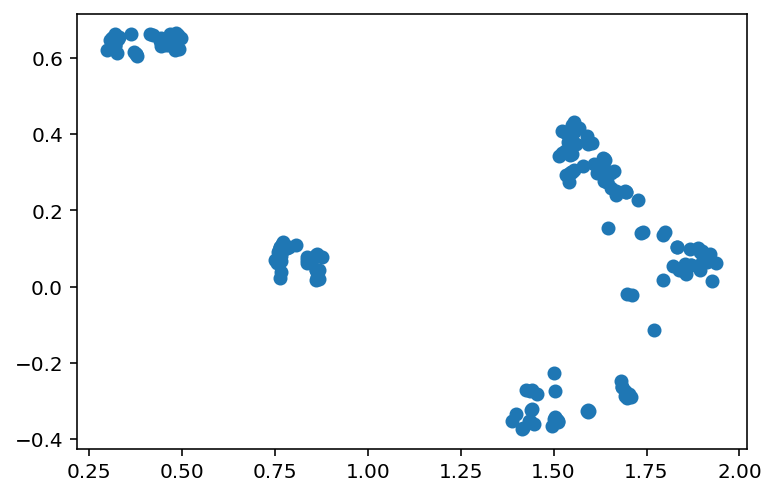

 41%|████      | 41/100 [00:21<00:33,  1.78it/s]

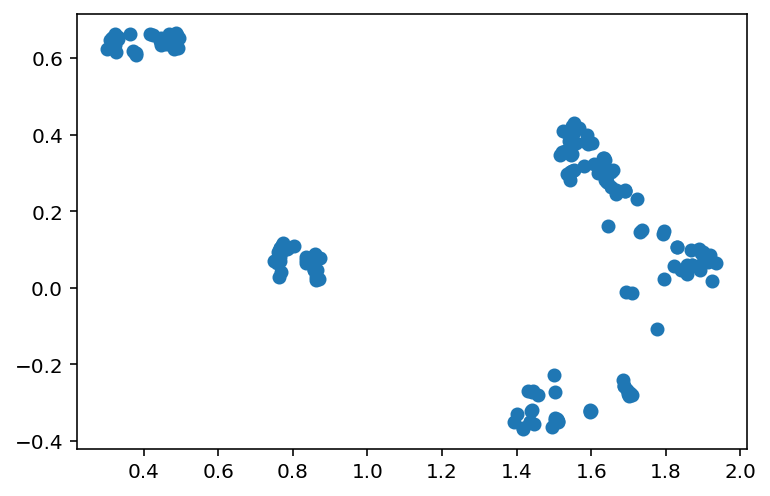

 42%|████▏     | 42/100 [00:22<00:32,  1.78it/s]

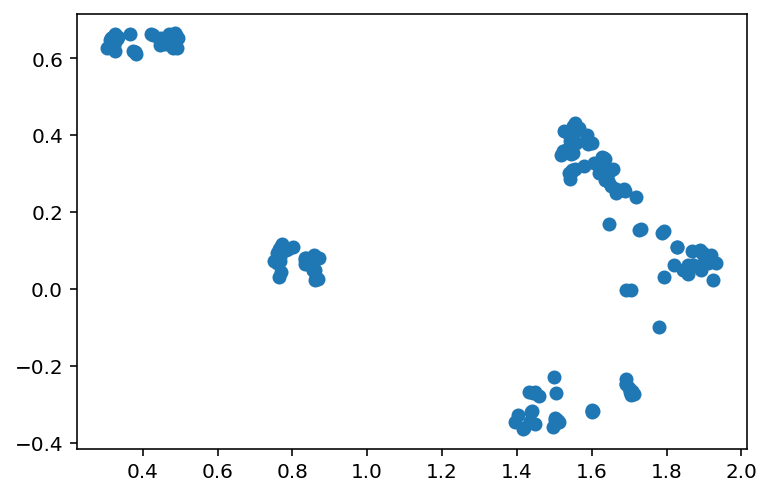

 43%|████▎     | 43/100 [00:22<00:32,  1.76it/s]

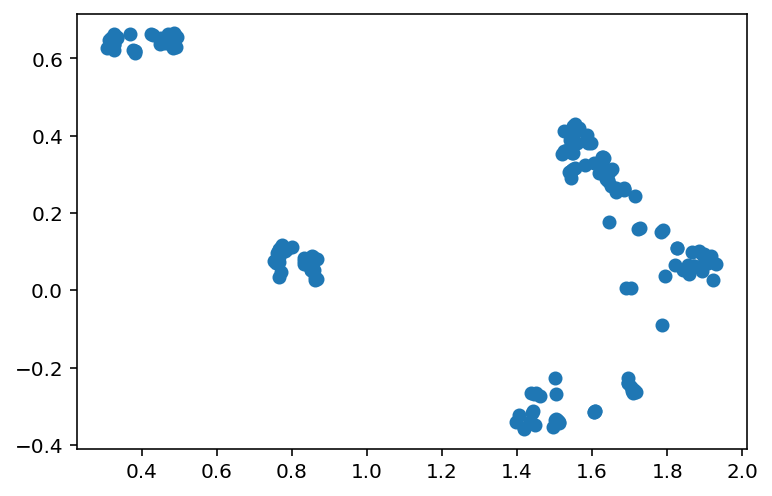

 44%|████▍     | 44/100 [00:23<00:32,  1.75it/s]

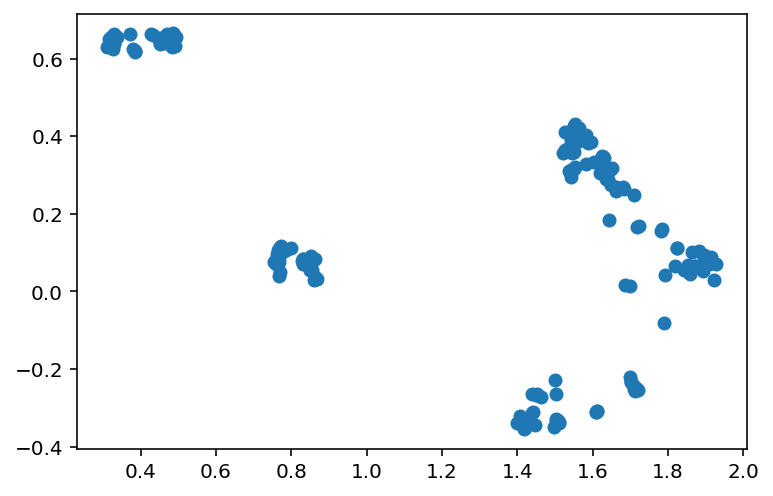

 45%|████▌     | 45/100 [00:24<00:31,  1.75it/s]

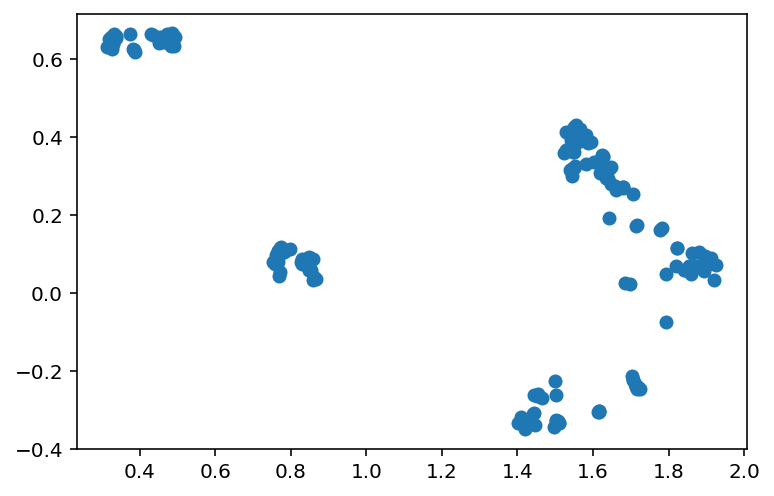

 46%|████▌     | 46/100 [00:24<00:31,  1.74it/s]

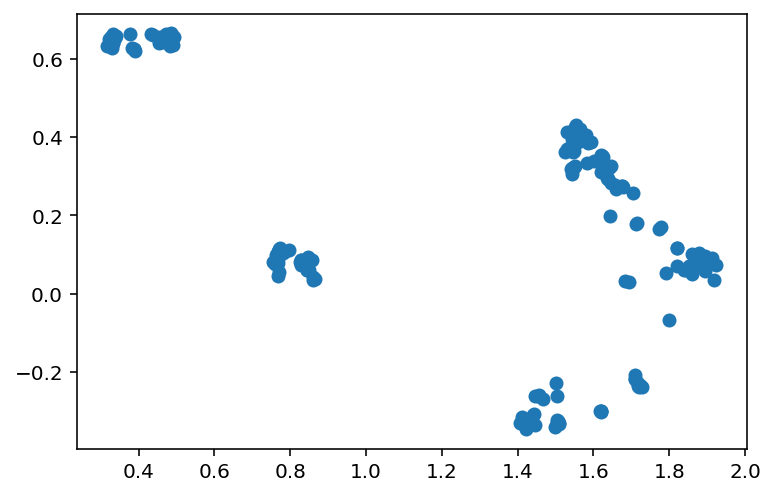

 47%|████▋     | 47/100 [00:25<00:30,  1.74it/s]

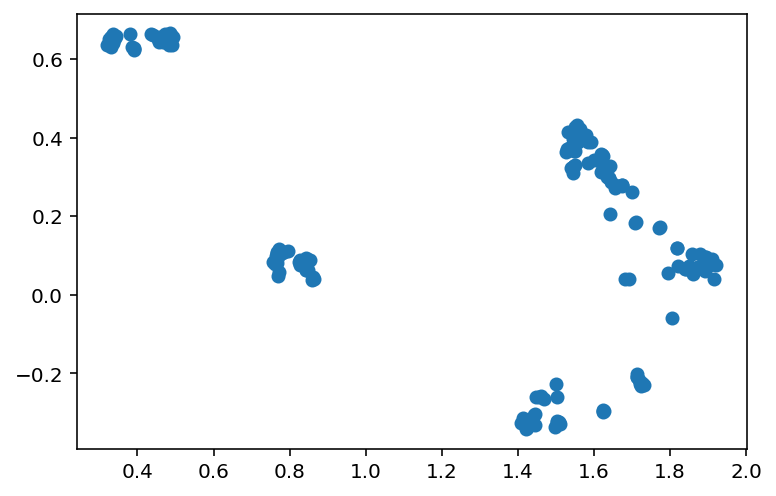

 48%|████▊     | 48/100 [00:25<00:29,  1.73it/s]

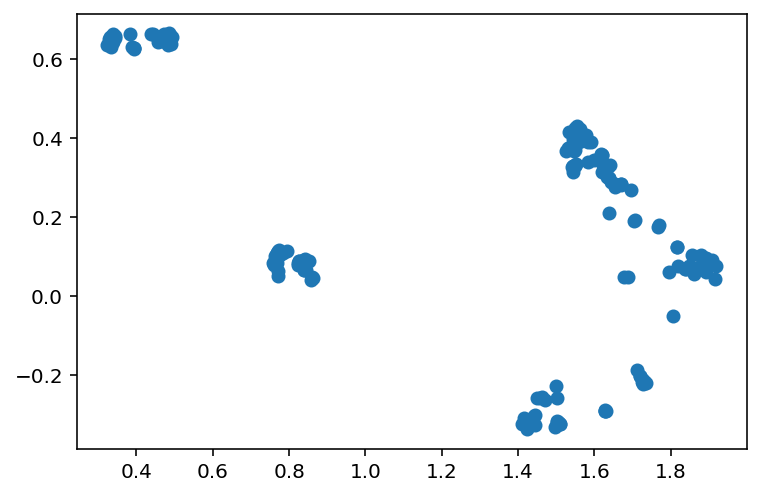

 49%|████▉     | 49/100 [00:26<00:29,  1.74it/s]

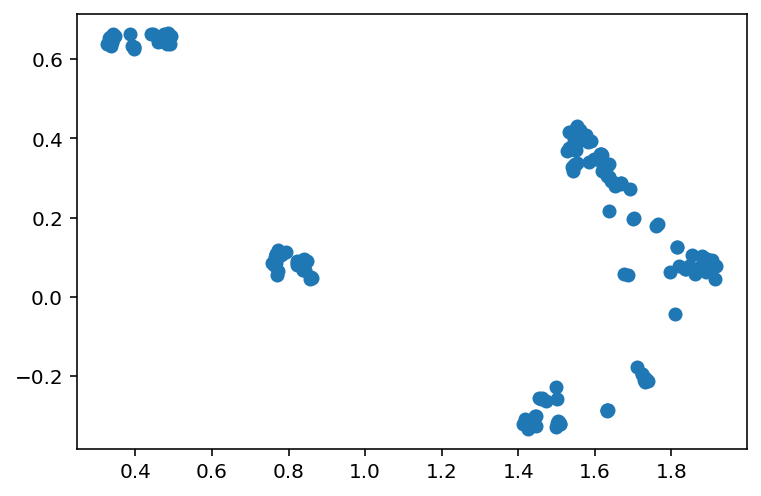

 50%|█████     | 50/100 [00:26<00:29,  1.72it/s]

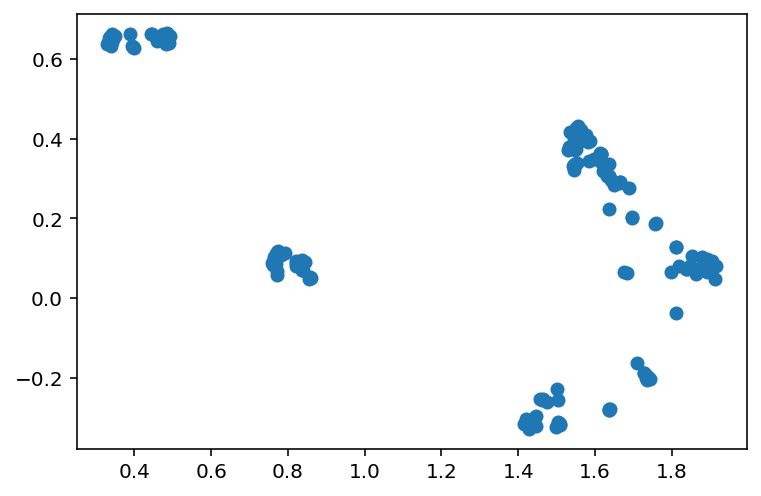

 51%|█████     | 51/100 [00:27<00:28,  1.70it/s]

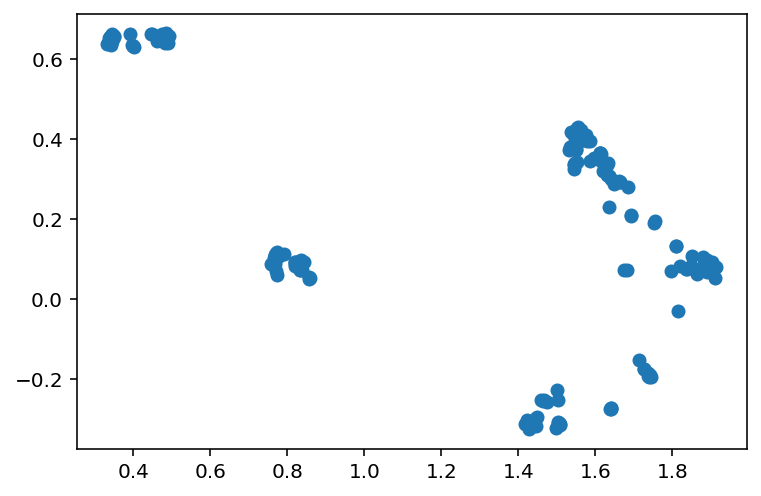

 52%|█████▏    | 52/100 [00:28<00:28,  1.71it/s]

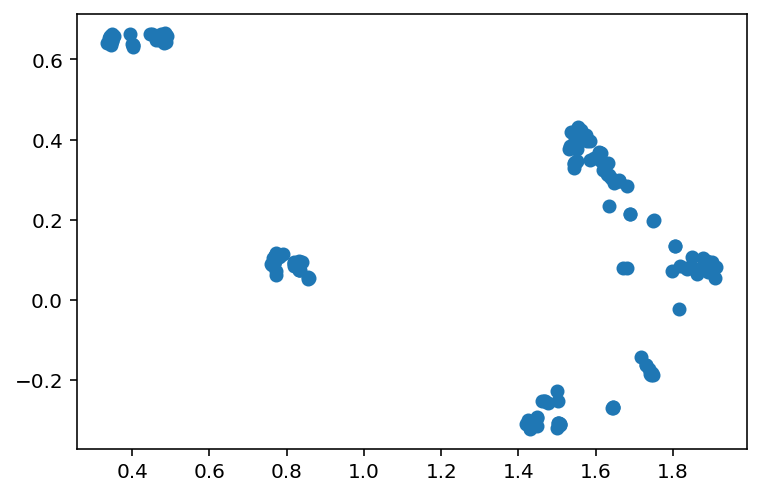

 53%|█████▎    | 53/100 [00:28<00:27,  1.71it/s]

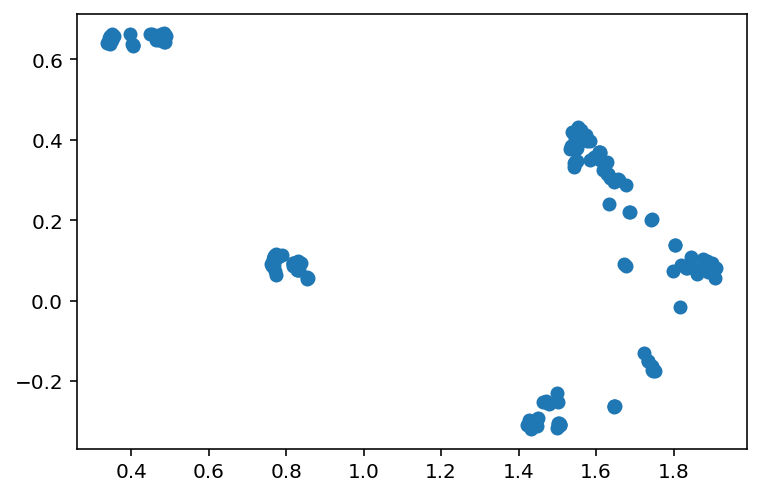

 54%|█████▍    | 54/100 [00:29<00:26,  1.71it/s]

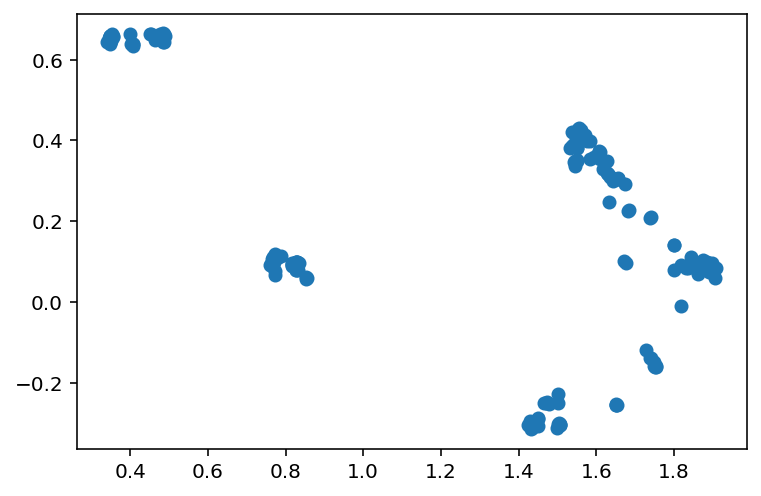

 55%|█████▌    | 55/100 [00:29<00:26,  1.70it/s]

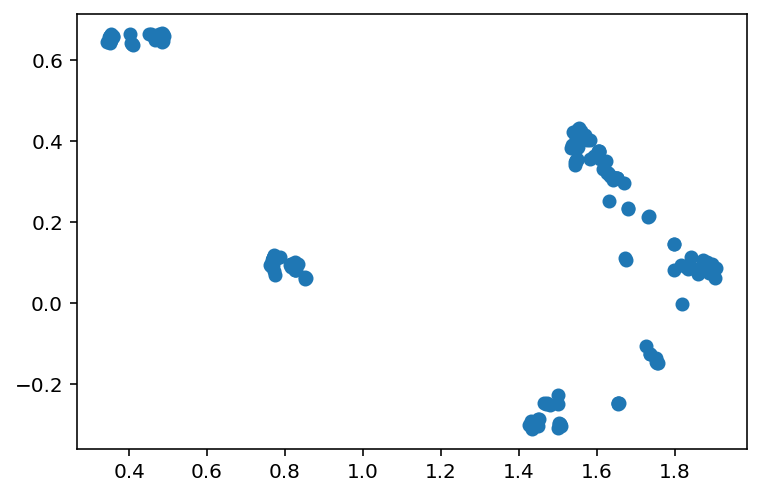

 56%|█████▌    | 56/100 [00:30<00:25,  1.70it/s]

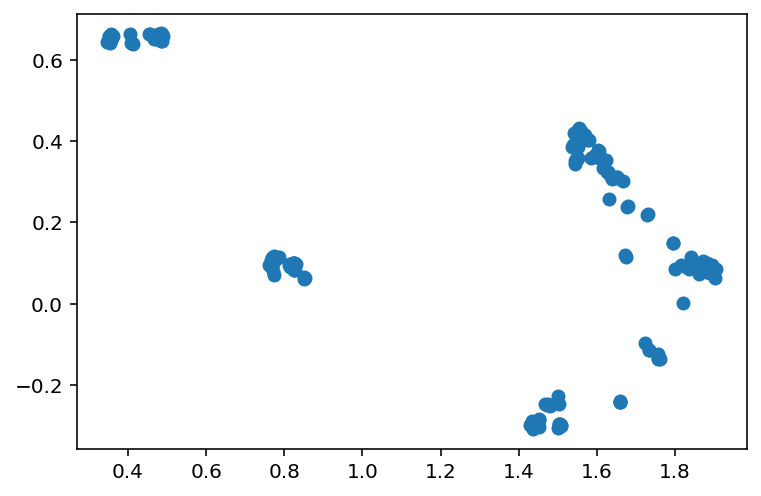

 57%|█████▋    | 57/100 [00:31<00:25,  1.70it/s]

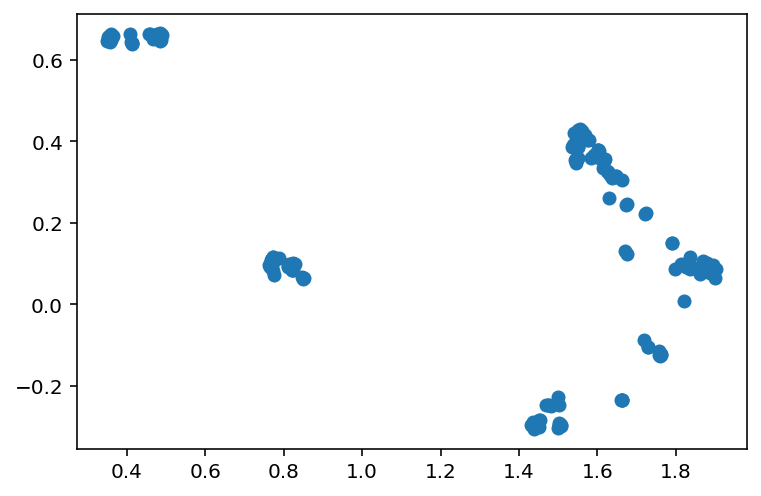

 58%|█████▊    | 58/100 [00:31<00:24,  1.70it/s]

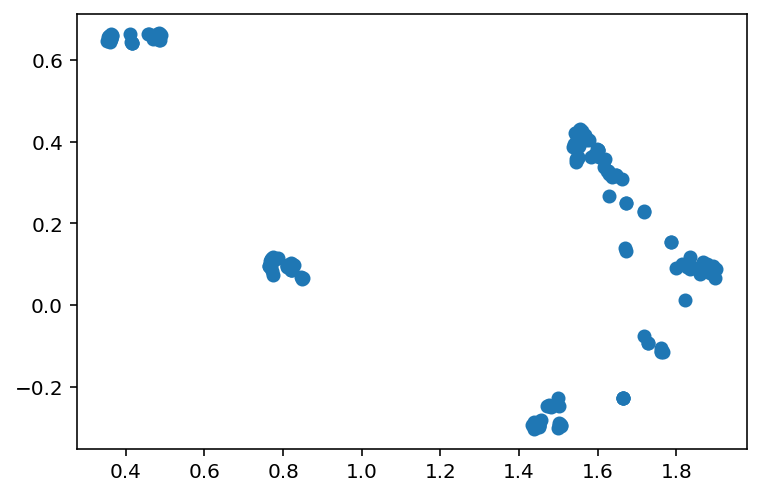

 59%|█████▉    | 59/100 [00:32<00:24,  1.69it/s]

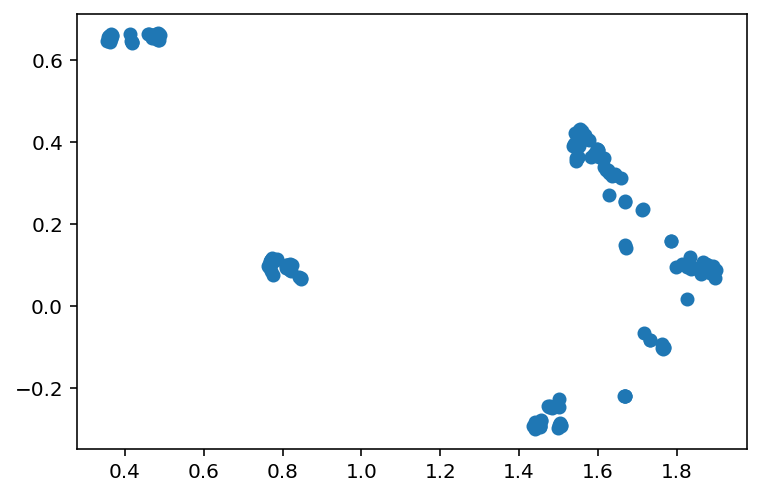

 60%|██████    | 60/100 [00:33<00:26,  1.54it/s]

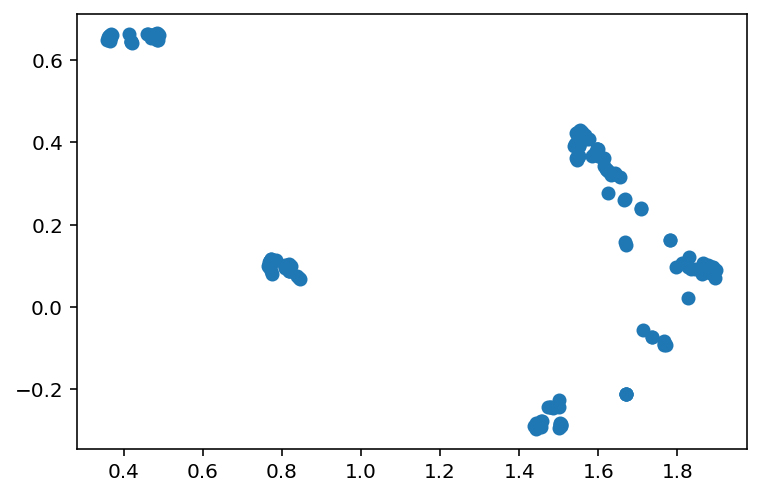

 61%|██████    | 61/100 [00:33<00:25,  1.55it/s]

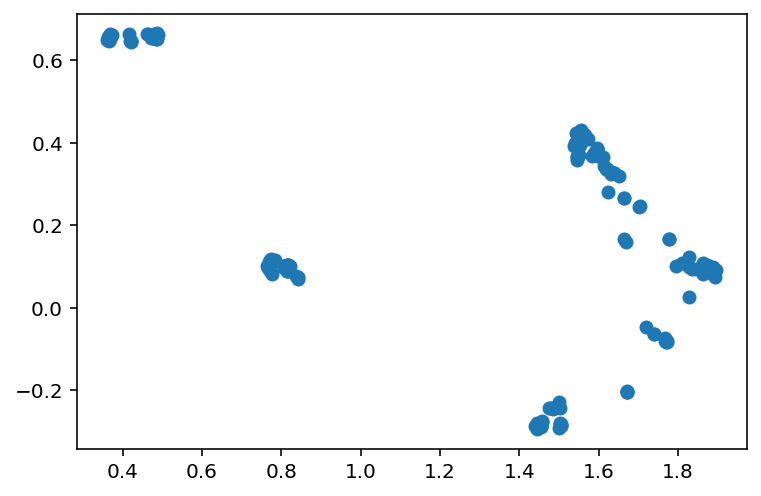

 62%|██████▏   | 62/100 [00:34<00:24,  1.58it/s]

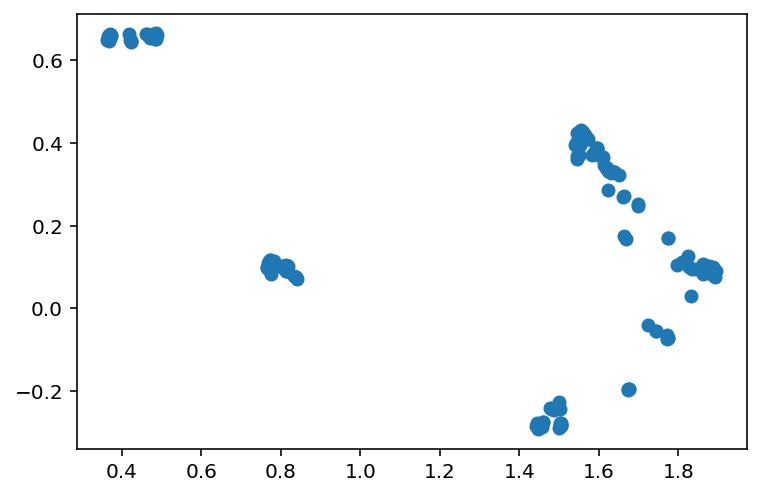

 63%|██████▎   | 63/100 [00:34<00:23,  1.59it/s]

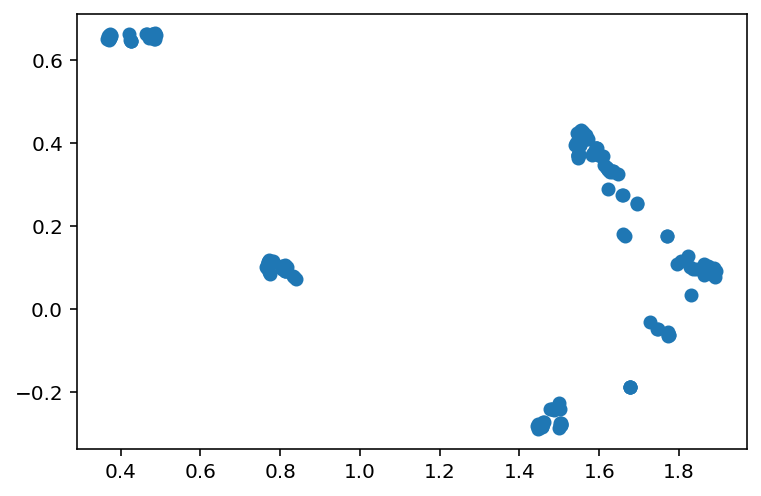

 64%|██████▍   | 64/100 [00:35<00:22,  1.61it/s]

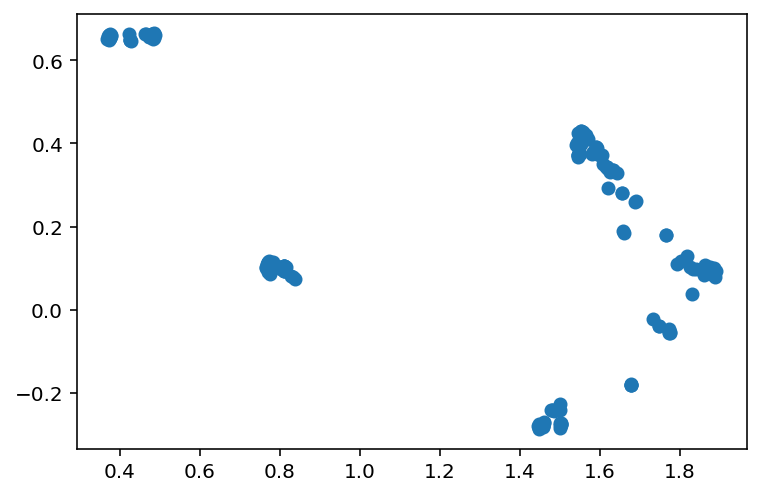

 65%|██████▌   | 65/100 [00:36<00:21,  1.61it/s]

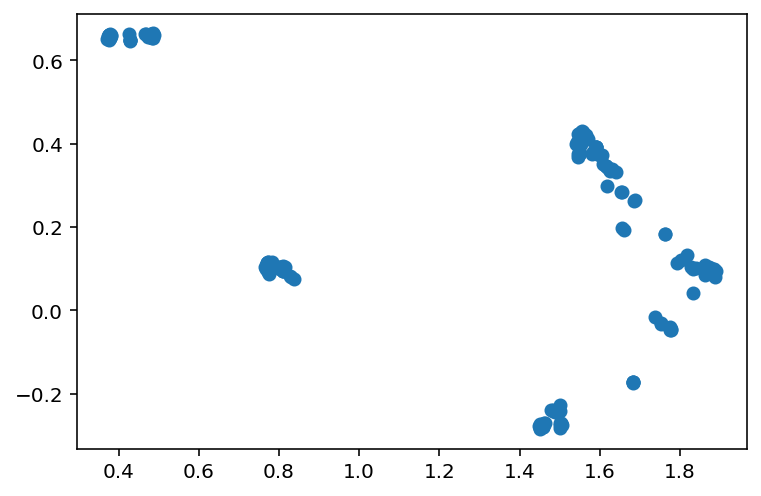

 66%|██████▌   | 66/100 [00:36<00:21,  1.62it/s]

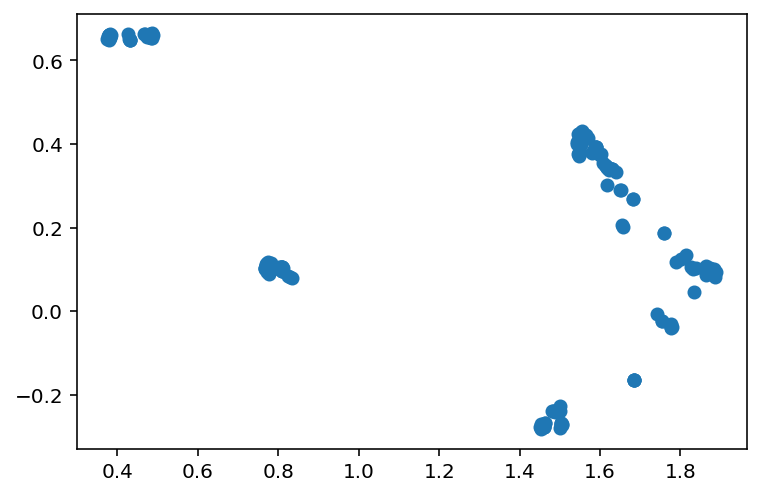

 67%|██████▋   | 67/100 [00:37<00:20,  1.62it/s]

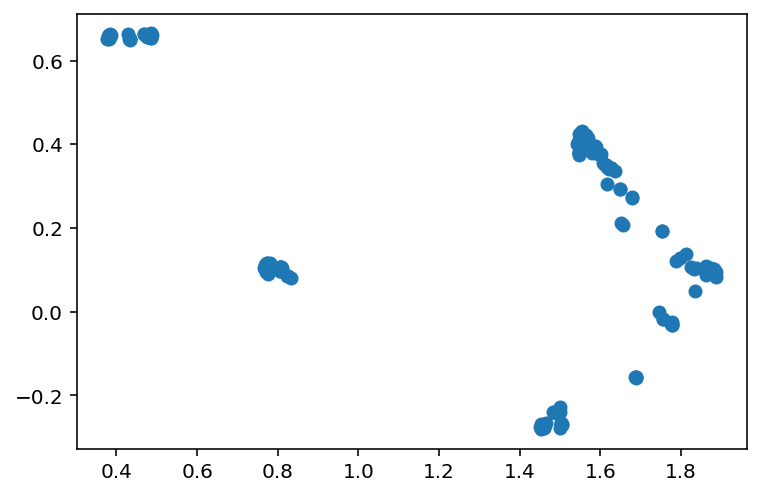

 68%|██████▊   | 68/100 [00:37<00:19,  1.61it/s]

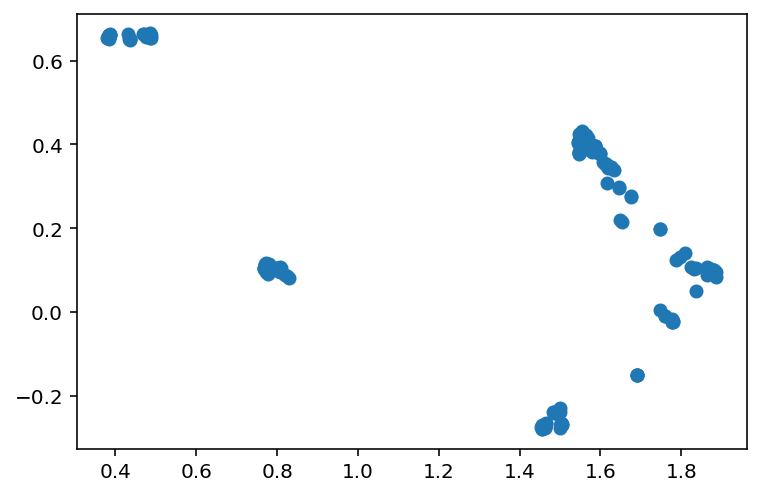

 69%|██████▉   | 69/100 [00:38<00:19,  1.62it/s]

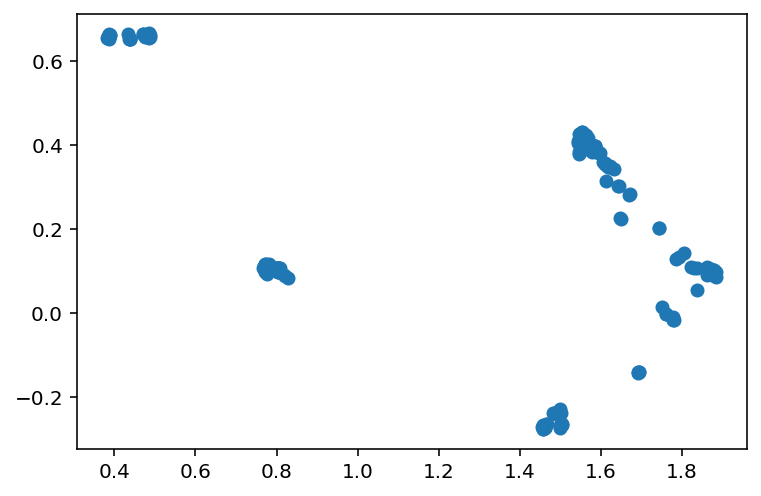

 70%|███████   | 70/100 [00:39<00:18,  1.61it/s]

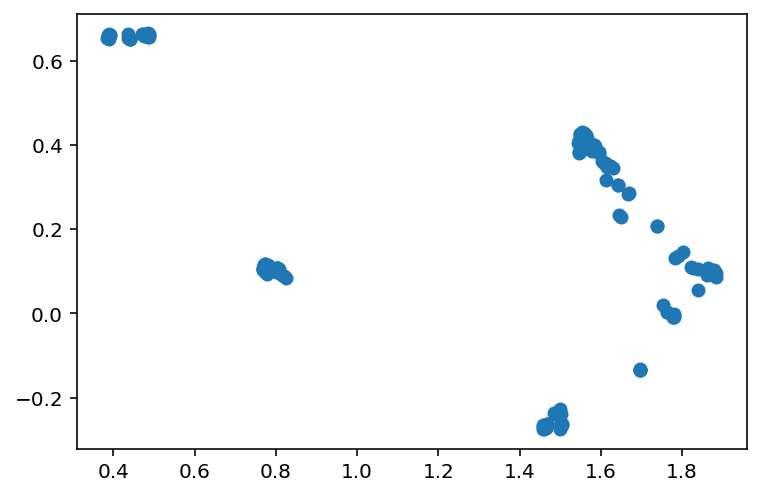

 71%|███████   | 71/100 [00:39<00:18,  1.60it/s]

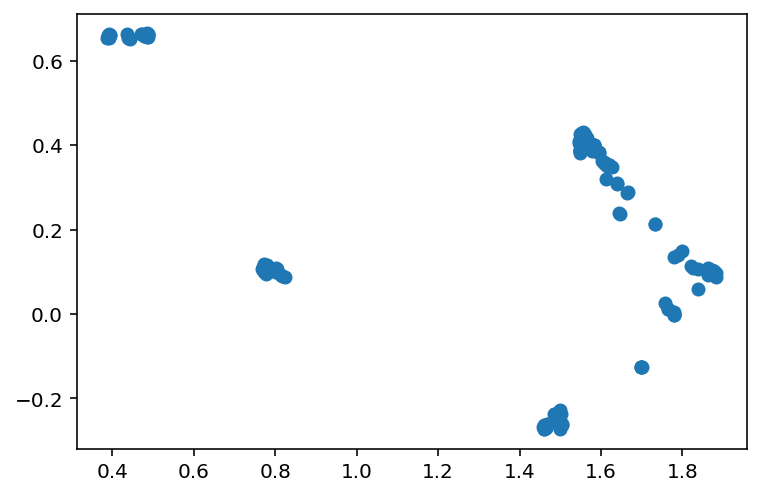

 72%|███████▏  | 72/100 [00:40<00:17,  1.60it/s]

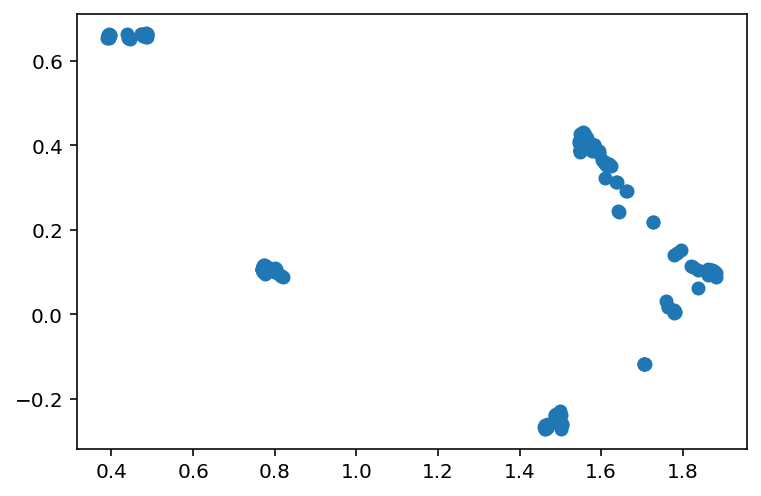

 73%|███████▎  | 73/100 [00:41<00:16,  1.60it/s]

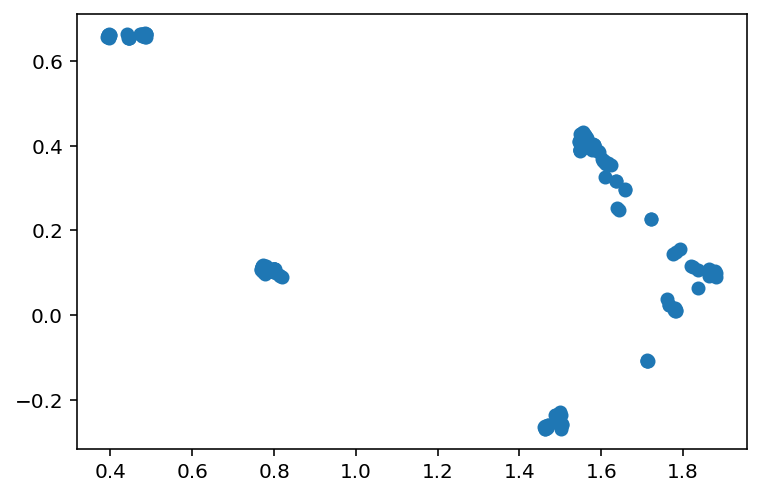

 74%|███████▍  | 74/100 [00:41<00:16,  1.59it/s]

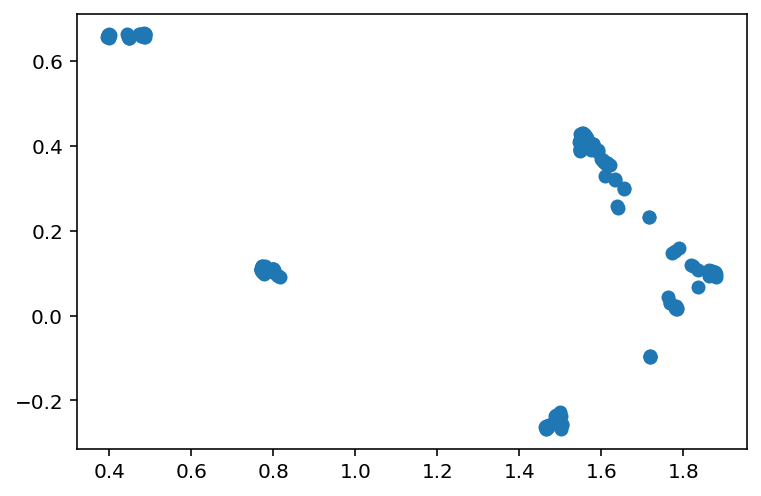

 75%|███████▌  | 75/100 [00:42<00:15,  1.59it/s]

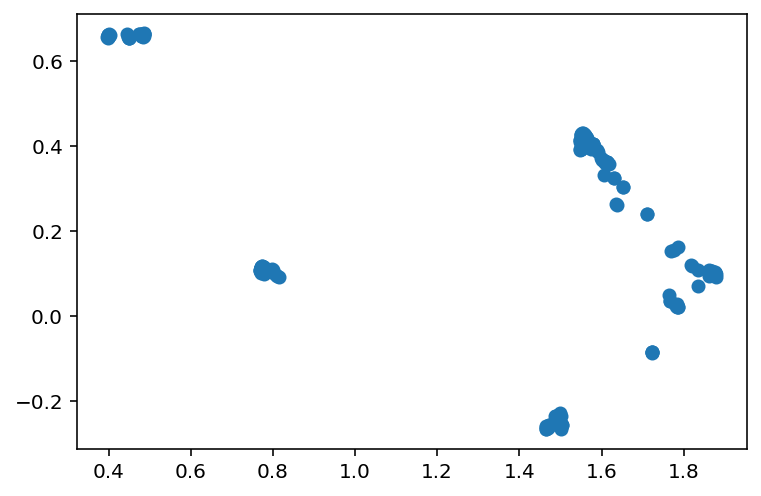

 76%|███████▌  | 76/100 [00:42<00:15,  1.58it/s]

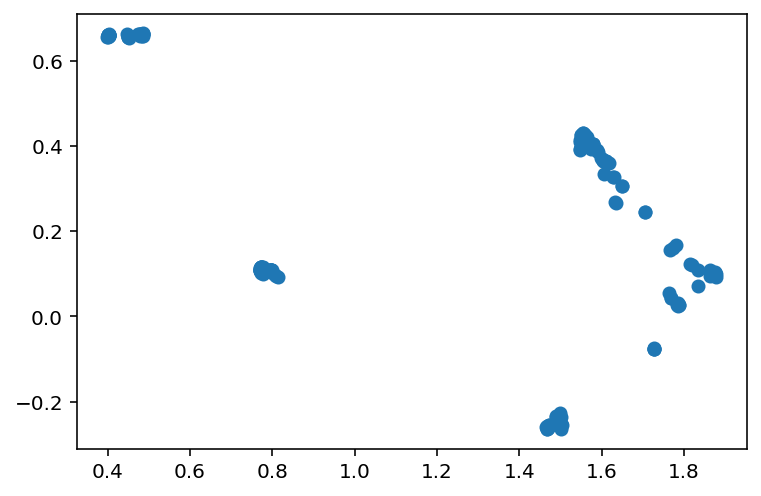

 77%|███████▋  | 77/100 [00:43<00:14,  1.58it/s]

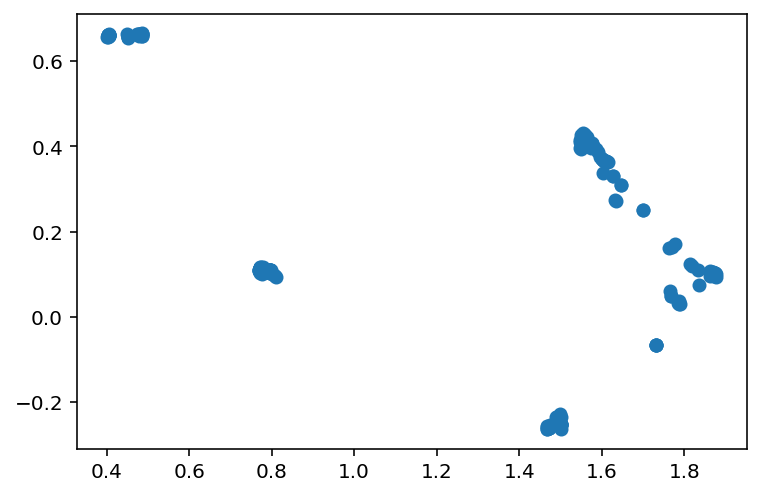

 78%|███████▊  | 78/100 [00:44<00:14,  1.56it/s]

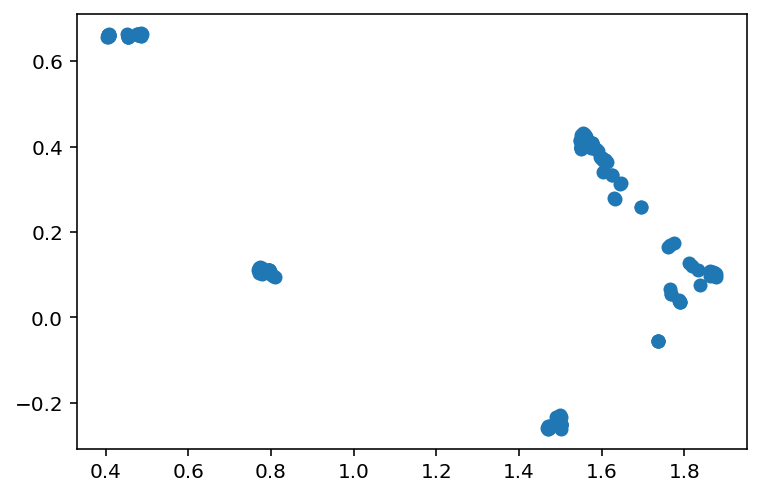

 79%|███████▉  | 79/100 [00:44<00:13,  1.56it/s]

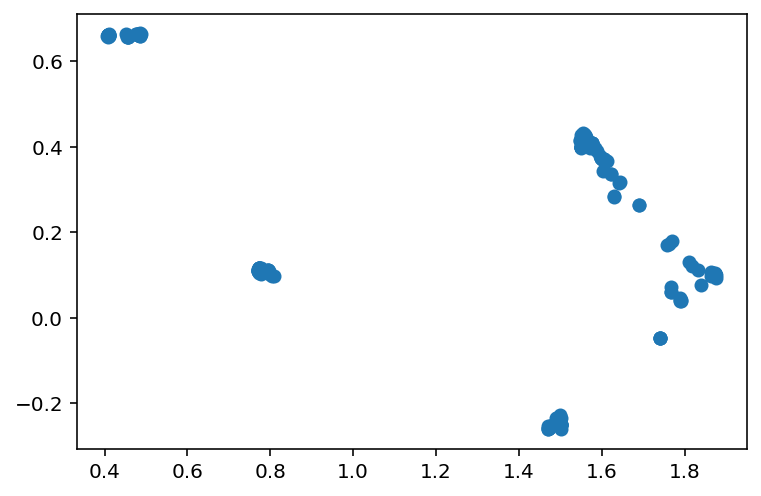

 80%|████████  | 80/100 [00:45<00:12,  1.56it/s]

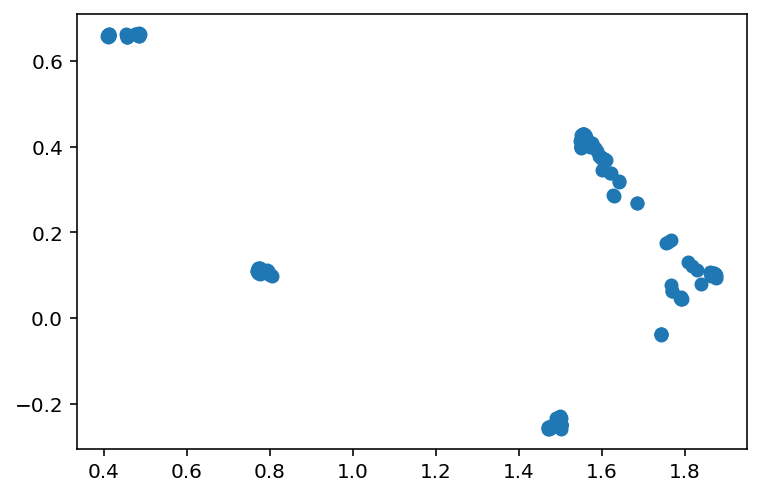

 81%|████████  | 81/100 [00:46<00:12,  1.55it/s]

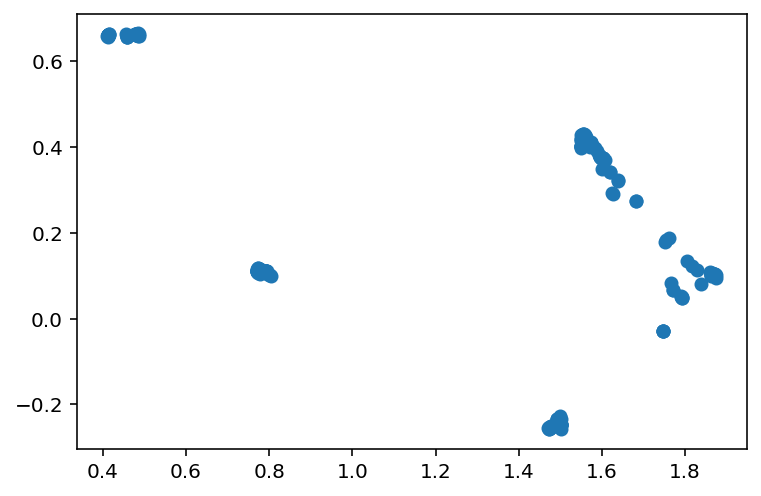

 82%|████████▏ | 82/100 [00:46<00:11,  1.55it/s]

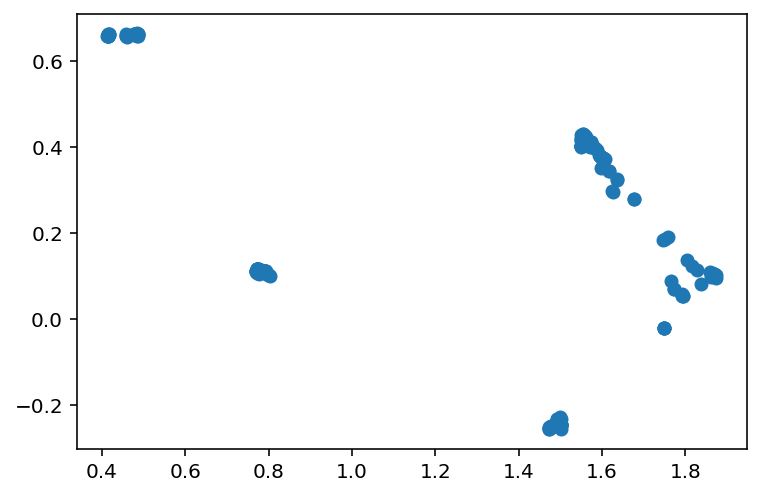

 83%|████████▎ | 83/100 [00:47<00:10,  1.55it/s]

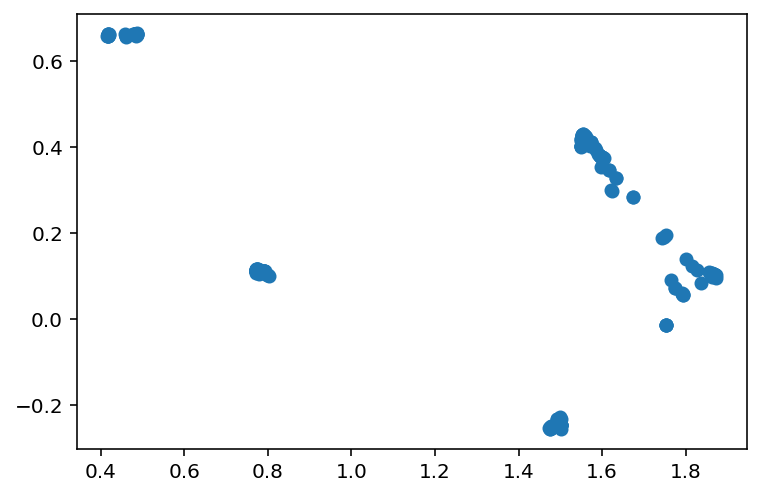

 84%|████████▍ | 84/100 [00:48<00:10,  1.54it/s]

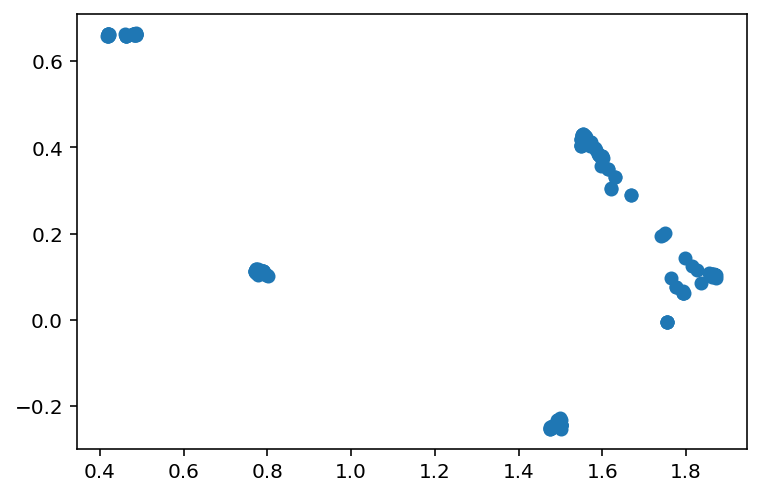

 85%|████████▌ | 85/100 [00:48<00:09,  1.54it/s]

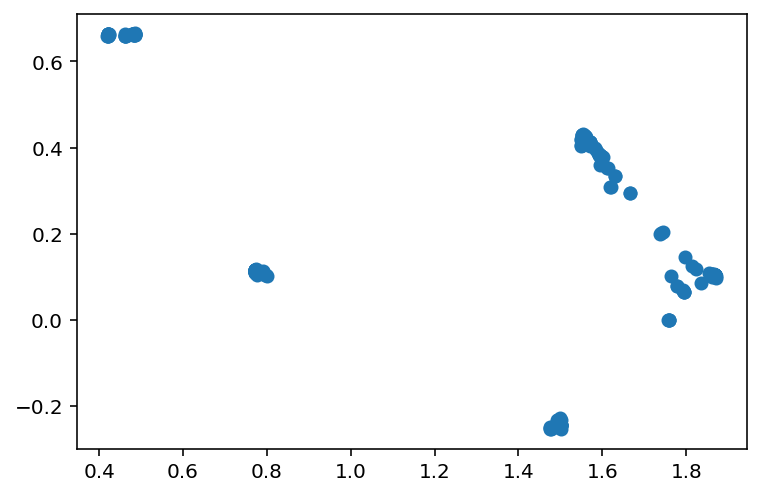

 86%|████████▌ | 86/100 [00:49<00:09,  1.53it/s]

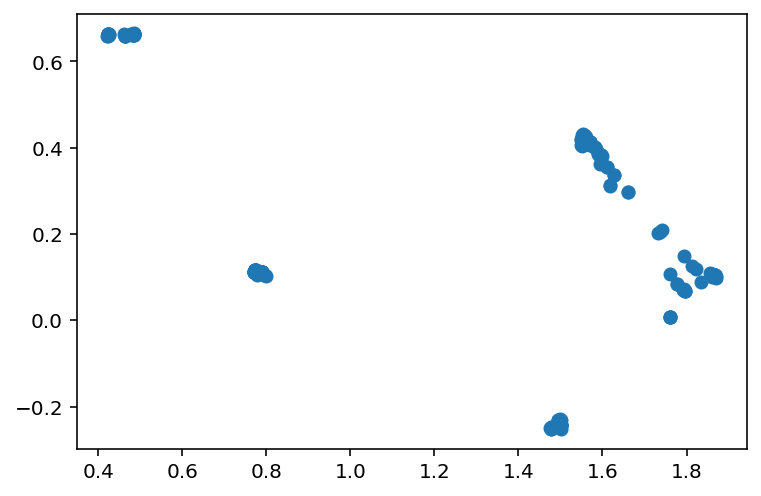

 87%|████████▋ | 87/100 [00:50<00:08,  1.53it/s]

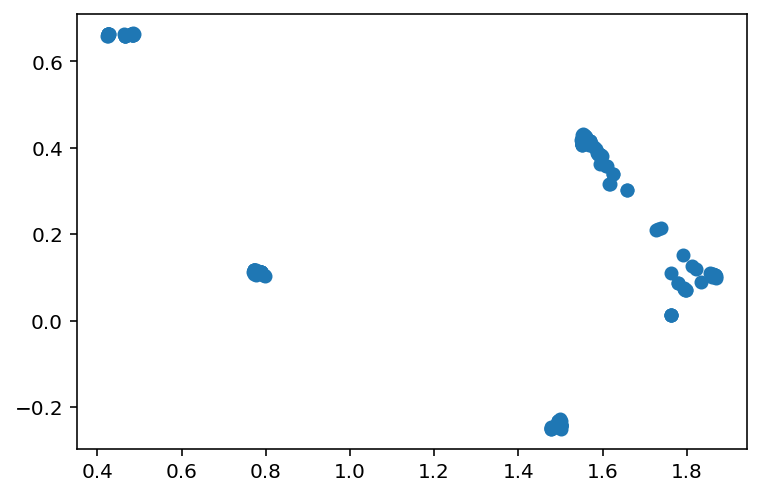

 88%|████████▊ | 88/100 [00:50<00:07,  1.52it/s]

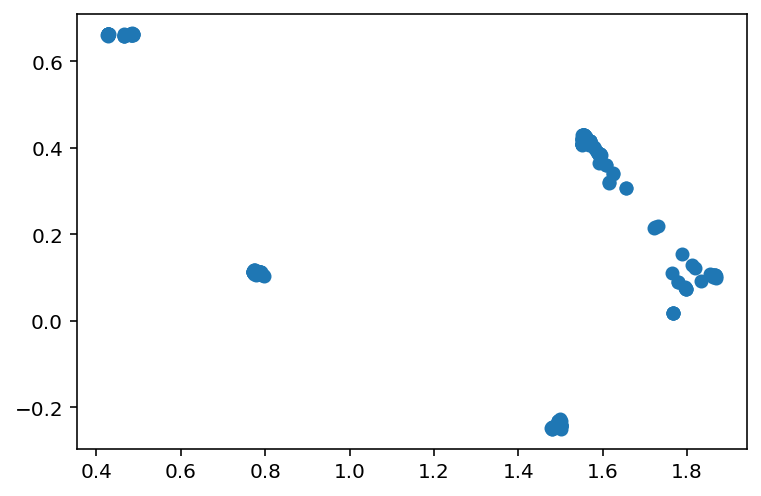

 89%|████████▉ | 89/100 [00:51<00:07,  1.51it/s]

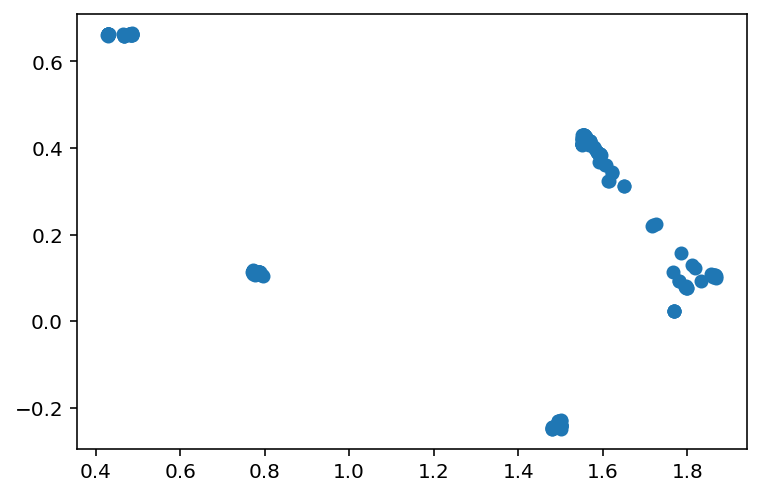

 90%|█████████ | 90/100 [00:52<00:06,  1.50it/s]

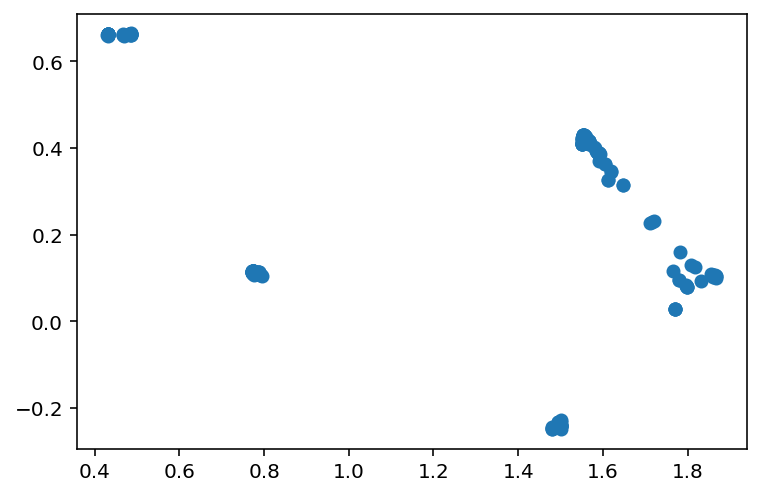

 91%|█████████ | 91/100 [00:52<00:06,  1.38it/s]

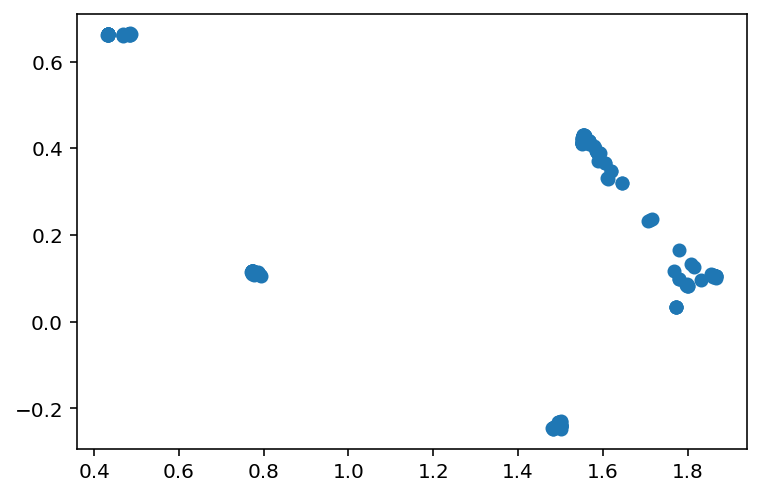

 92%|█████████▏| 92/100 [00:53<00:05,  1.41it/s]

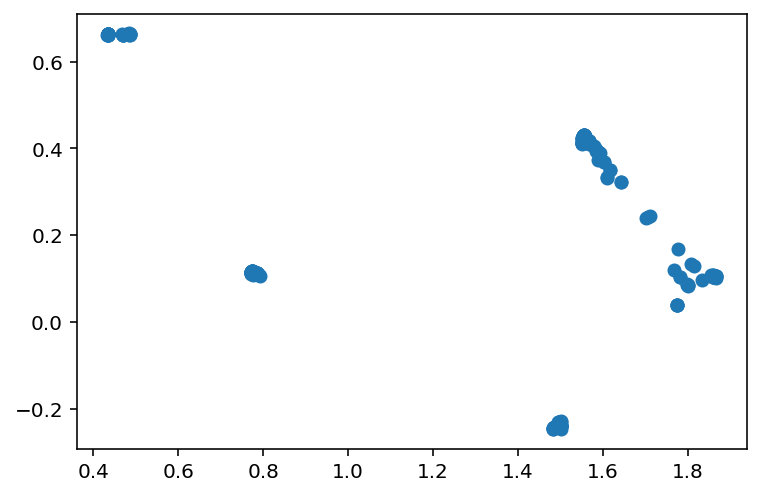

 93%|█████████▎| 93/100 [00:54<00:04,  1.42it/s]

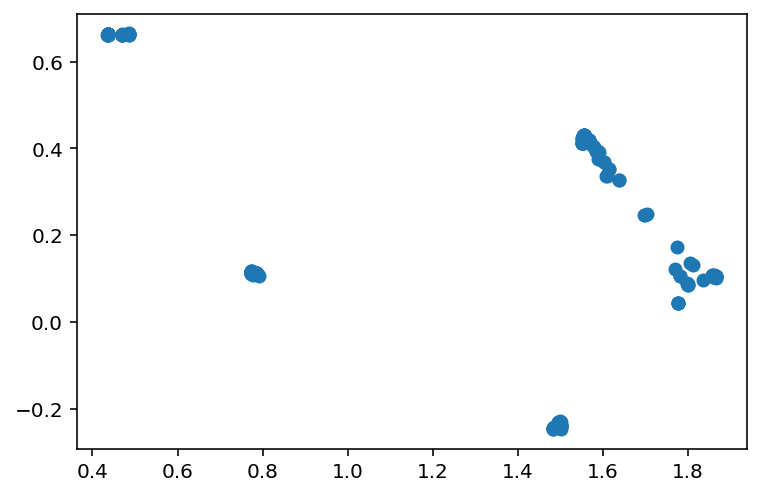

 94%|█████████▍| 94/100 [00:55<00:04,  1.43it/s]

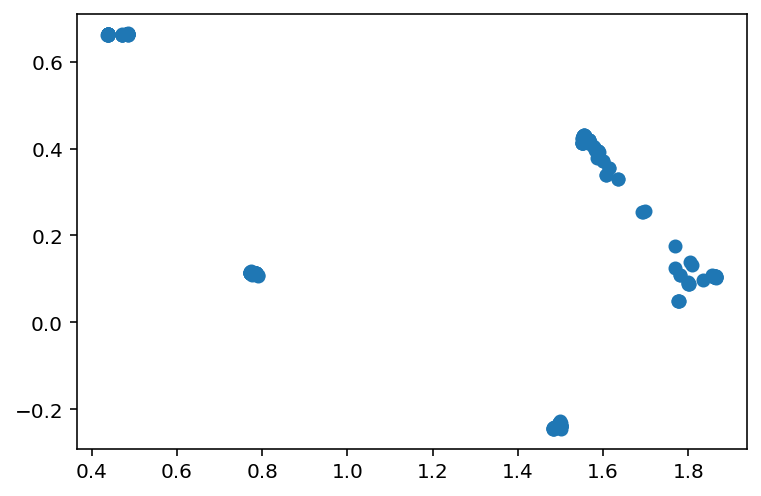

 95%|█████████▌| 95/100 [00:55<00:03,  1.45it/s]

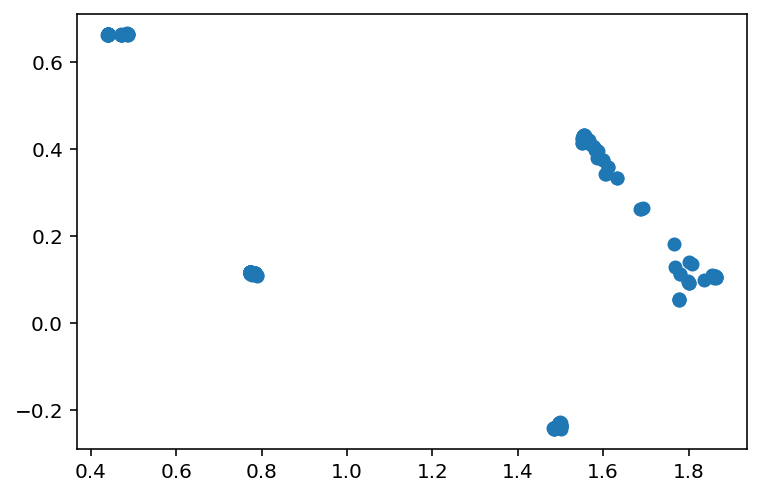

 96%|█████████▌| 96/100 [00:56<00:02,  1.45it/s]

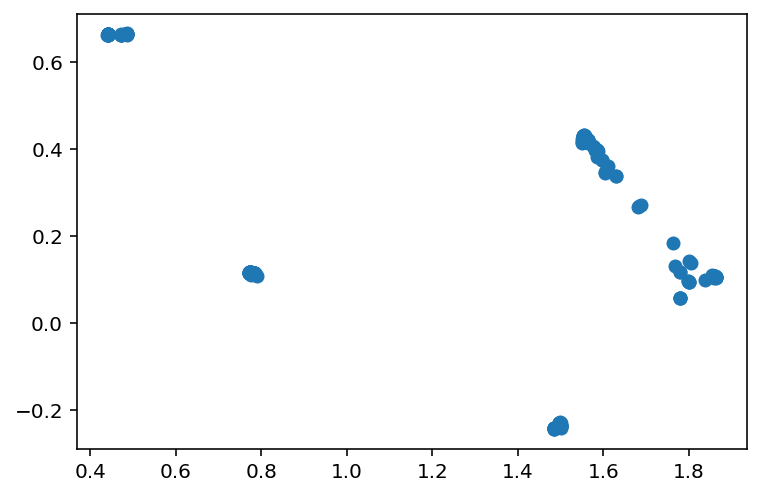

 97%|█████████▋| 97/100 [00:57<00:02,  1.45it/s]

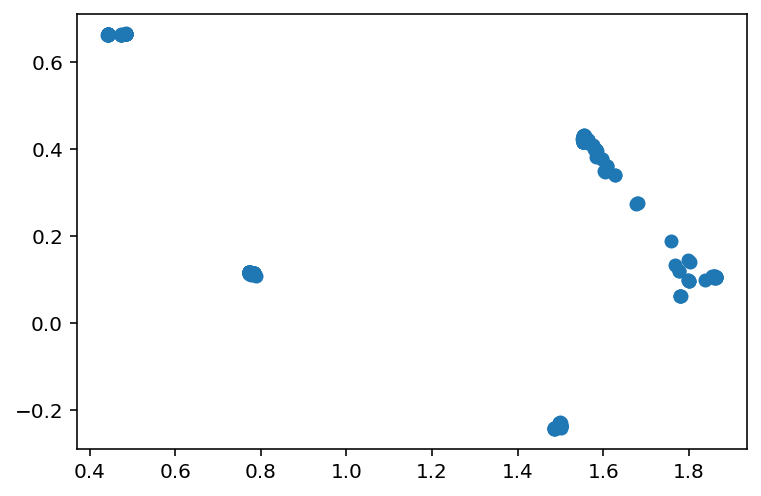

 98%|█████████▊| 98/100 [00:57<00:01,  1.44it/s]

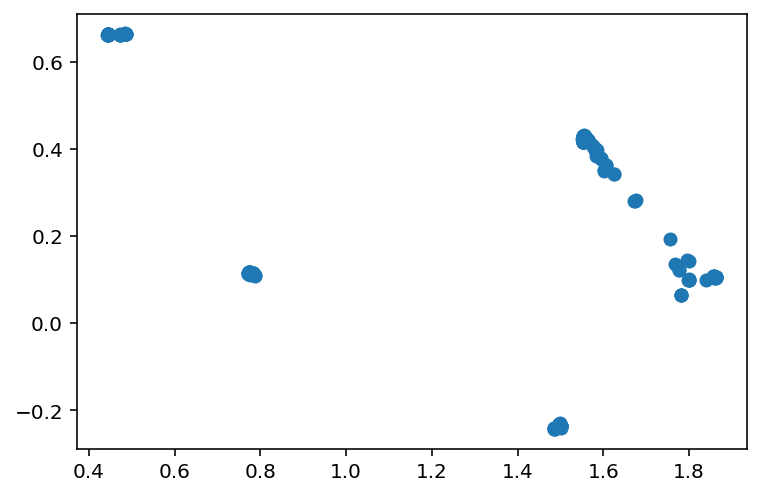

 99%|█████████▉| 99/100 [00:58<00:00,  1.44it/s]

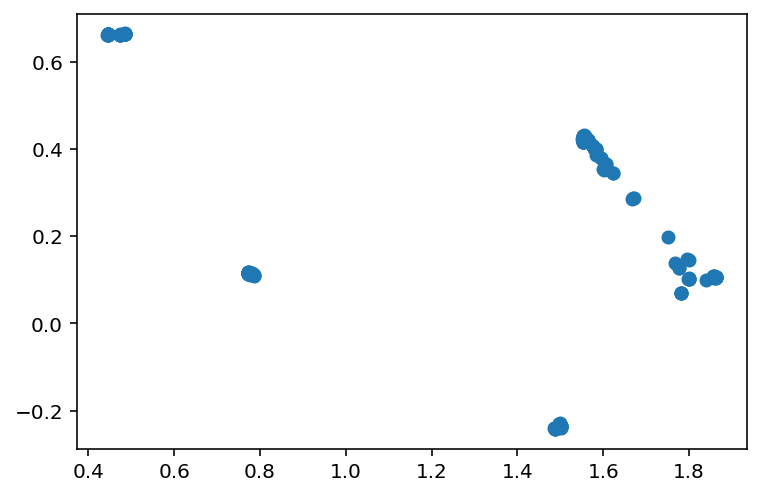

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


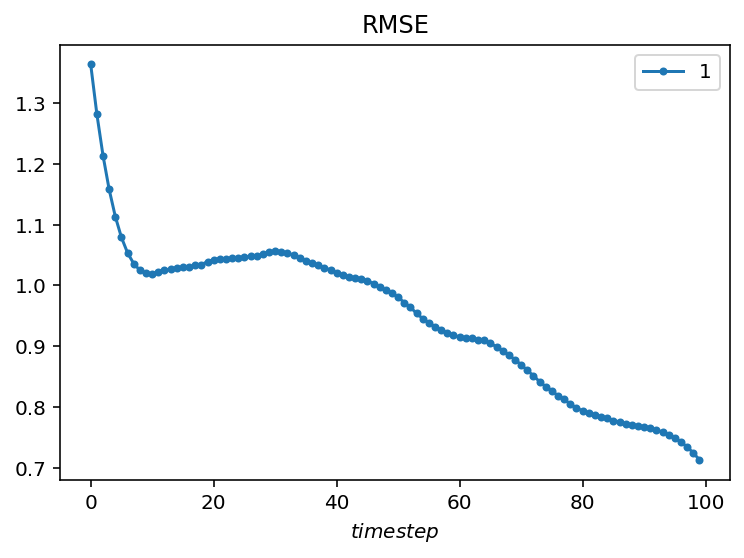

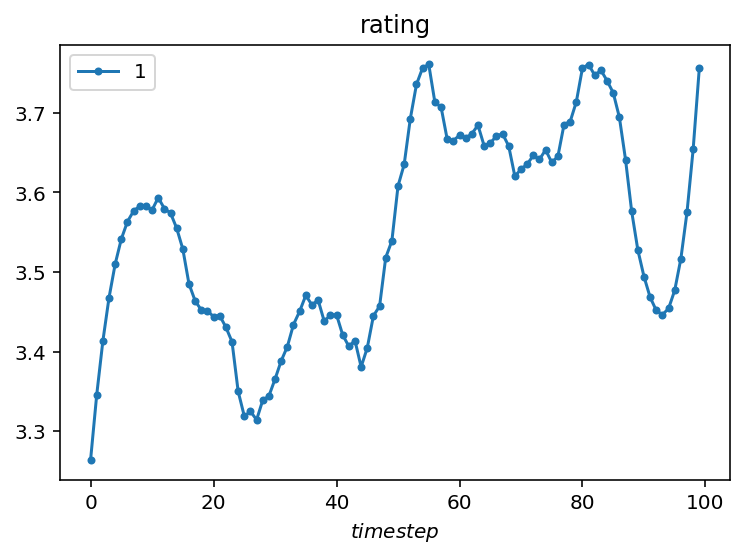

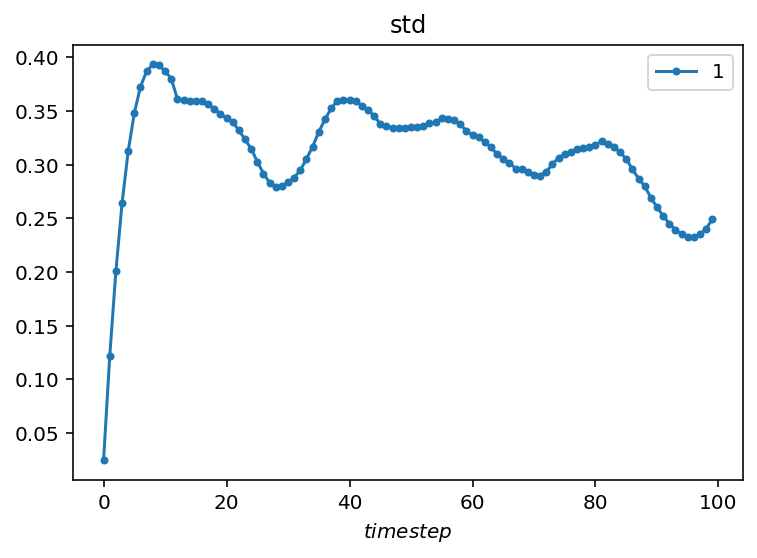

In [19]:
NUM_USERS = 100
NUM_ITEMS = 200
STEPS = 100
DIM = 1
MEMORY_LENGTH = 5
NUM_CLUSTERS = 5
M = int(0.5*NUM_ITEMS/NUM_CLUSTERS)
ALPHA = 0.05

env = LatentFactorBehavior_MLHB(latent_dim=DIM, 
                           num_users=NUM_USERS,
                           num_items=NUM_ITEMS,
                           affinity_change=0,
                           rating_frequency=1,
                           num_init_ratings=NUM_USERS*NUM_ITEMS//100, 
                           memory_length=MEMORY_LENGTH)

env.seed(0)
items, users, ratings = env.reset()
create_clusters(env, NUM_CLUSTERS, 0.1)

recommender = LibFM_MLHB(num_user_features=0,
                    num_item_features=0,
                    num_rating_features=0,
                    max_num_users=NUM_USERS,
                    max_num_items=NUM_ITEMS,
                    seed=0)
recommender.reset(items, users, ratings)
plot_items(env, recommender)
losses, avg_ratings, mean_stds, _, _ = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[RMSE, avg_rec_rating, recs_stds, lambda e, r: modify_items(e, r, M, ALPHA), plot_items], reset=False)

plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title='rating')
plot_graphs(mean_stds, title='std', smooth=True)

### 2.1.2 Results
Based on your results (and **without** looking at the underlying supplier code), try to guess how and according to what each supplier acts at each iteration.

```
Answer: We start with suppliers offering a variety of different items. Then, suppliers learn what are the popular items, and start offering more similar items (reflecting in items with closer features' values). It can be observed by the lowing variability of items, resulting in more dense clusters. 
```

What effects of this sort of strategic behavior did you observe? What impact do they have on the environment and on the recommender?

```
Answer: The strategic behavior of suppliers changes the distribution of the items over time, and makes it harder for the recommender to improve over time, which realizes in a lower and more variable ARRI over time on average compared to the non-strategic environment. Adding exploration as in section 1 may help the recommender. 
```

# Part 3: Dynamics + Strategies
**Guidelines:**
The next exercise is highly open-ended. It relies on and
combines many of the key elements and ideas that appeared throught our course. Be creative! You are free to try out **any approach** you feel is reasonable --- as long as you can explain its underlying rationale. Also, remember that it's perfectly fine if you don't get the results you were hoping for. If this happens - try to unerstand *why*, and write down your thoughts.

In this section, our environment simulates a social media environment in which **users are also suppliers**.
Here, users produce content items like images and videos (and therefore act as a "supplier" that owns an item), but also consume content generated by other users (and thus act as a "user").

In this environment users have **money** and their goal is to maximize their income over time. Users gain money when other users choose their items, but loose money (i.e., spend or invest) when they choose items of other users.
The system, on the other hand, has one goal, which is to **maximize user engagement** (in particular, it does not care about the financial state of its users).
The two goals are linked by the fact that items with higher ratings are more costly (think of this as set by supply and demand). Hence, 
as suppliers, users gain more from high-rating items, but as consumers, pay more for these type of items.

Money and engagement are therefore not only highly dependent, but are a pair of cause-and-effect variables that are linked within a closed feedback loop. The crucial component here is that this feedback is mediated by the system through how it recommends.

In the simluation, each user $i$ has a two time-dependent variables: a `money` variable $m_i^{(t)}$ and an `engagement` variabe $e_i^{(t)}$. These are updated at each time step using the following update rules:
* $m_i^{(0)}=e_i^{(0)}=1$
* $m_i^{(t+1)} = m_i^{(t)} + \alpha_i^{(t)}  m_i^{(t)} - \beta_i^{(t)}  m_i^{(t)} e_i^{(t)}$
* $e_i^{(t+1)} = e_i^{(t)} + \beta_i^{(t)}  m_i^{(t)} e_i^{(t)} - C  e_i^{(t)}$

where:
* *Money growth rate* (MGR): $\alpha_i^{(t)} = \phi(\text{average rating of item $i$ across all users at time $t$})$
* *Engagement growth rate* (EGR): $\beta_i^{(t)} = \phi(\text{user $i$'s average rating of items recommended to him at time $t$})$
* *Engagement decay rate*: $C$ is a predefined constant

for some non-linear monotonic activation function $\phi$.


In words, the following dynamics updates occur at each time step:
* Money:
  * Each user earns income from her item. The amount of income is proportional to the item's average rating (across all users). The higher the rating, the higher the income.
  * Each user spends money on other items. The amount of money spent is proportional to (i) the amount of money he currently has, and
  (ii) the average rating of chosen items (so that higher rated items are more expensive).
* Engagement:
  * Each user's engagement increases in proportion to (i) her current income, and (ii) the average rating of items that were recommended to her.
  * A user's engagement decreeses in proportion to her amout of engagement (think of this as *usage friction* - getting tired, or losing interest).

**No need to read and understand the following codeblocks.**


In [20]:
import collections

def sigmoid(x):
  x = (x-3.8)*3
  return 4/(1 + np.exp(-x))+1

def step(money, engagement, user_item_avg_rating, user_rec_rating):
  def normalize_rating(rating):
    return 0.09*(np.clip(sigmoid(rating), 1, 5)-1)/(5-1) + 0.01

  A = normalize_rating(user_item_avg_rating)
  B = normalize_rating(user_rec_rating)
  money_next = np.clip(money + A*money - B*money*engagement, 0, 10)
  engagement_next = np.clip(engagement + B*money*engagement - 0.05*engagement, 0, 10)
  return money_next, engagement_next

def initialize_state(env, recommender):
  for user in env.users:
    env.users[user] = np.ones(2)

def update_state(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  for user, item in enumerate(np.array(recommendations).flatten()):
    money, engagement = env.users[user]
    user_item_avg_rating = np.mean(true_ratings[:, user])
    user_rec_rating = true_ratings[user, item]

    money_next, engagement_next = step(money, engagement, user_item_avg_rating, user_rec_rating)
    env.users[user] = np.array([money_next, engagement_next])
  return np.array(list(env.users.values()))

## 3.1 Simulation
Run the simulation to view how `money` and `engagement` change over time for users 1-10. The average amount of money and engagement across all users is also printed at the end. No need to modify the code in any way.

100%|██████████| 300/300 [06:28<00:00,  1.30s/it]


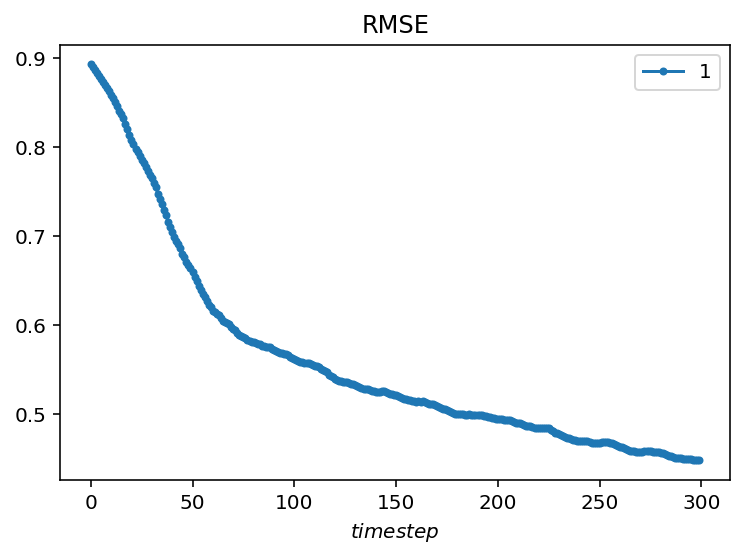

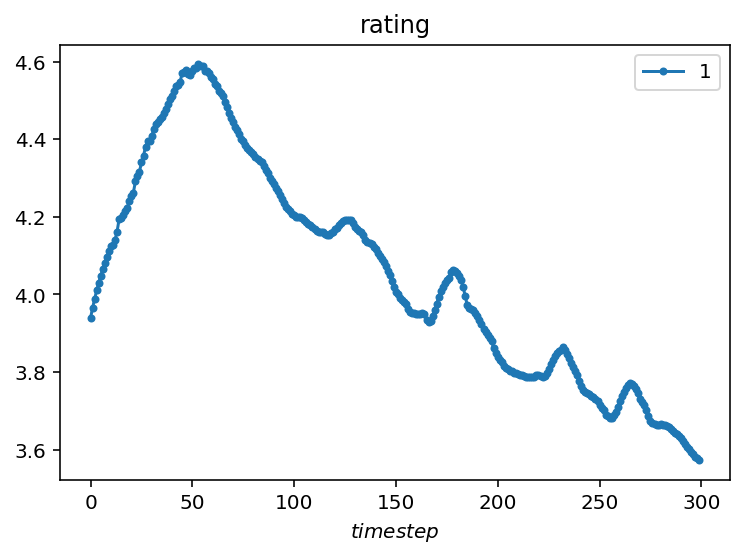

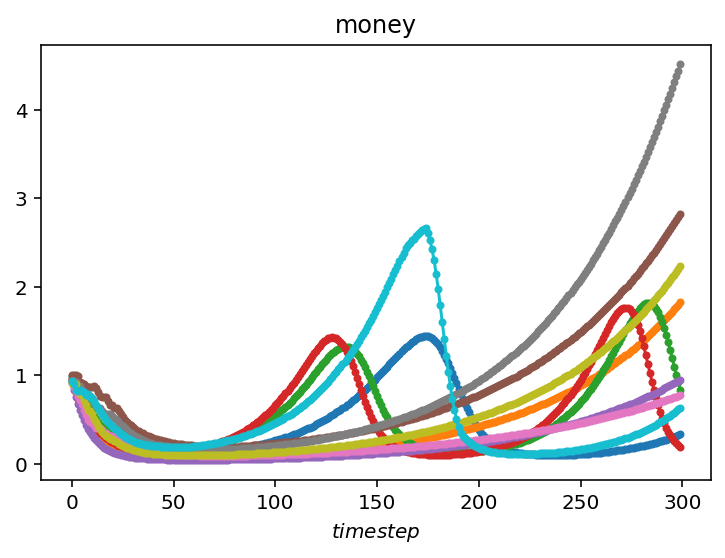

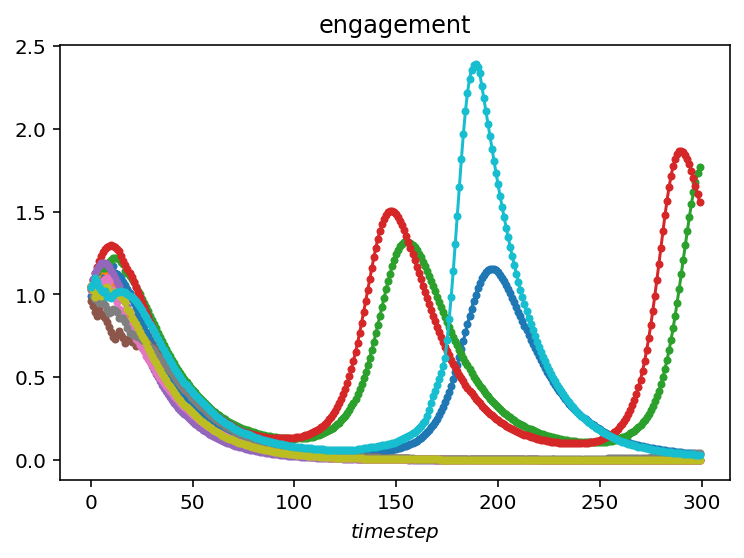

Average amount of money: 0.9128174155321371
Average amount of engagement: 0.40294723237216024


In [21]:
NUM_USERS = 300
STEPS = 300
DIM = 5

# initialize environment and recommender
env = LatentFactorBehavior_MLHB(latent_dim=DIM, 
                           num_users=NUM_USERS,
                           num_items=NUM_USERS,
                           affinity_change=0,
                           rating_frequency=0.2,
                           num_init_ratings=NUM_USERS*NUM_USERS//100)

recommender = LibFM_MLHB(num_user_features=0,
                          num_item_features=0,
                          num_rating_features=0,
                          max_num_users=NUM_USERS,
                          max_num_items=NUM_USERS,
                          seed=0)
env.seed(0)
items, users, ratings = env.reset()
recommender.reset(items, users, ratings)
initialize_state(env, recommender)

# run simulation
losses, avg_ratings, users_features = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[RMSE, avg_rec_rating, update_state], reset=False)

# plot graphs
plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title="rating")
plot_graphs(np.array(users_features)[:, :10, 0].tolist(), title='money', legend=False, smooth=False)
plot_graphs(np.array(users_features)[:, :10, 1].tolist(), title='engagement', legend=False, smooth=False)

print("Average amount of money: " + str(np.mean(np.array(users_features)[:, :, 0])))
print("Average amount of engagement: " + str(np.mean(np.array(users_features)[:, :, 1])))

## 3.2 Pick a side!
Choose whether you want to help users maximize their income, or help the recommendation system maximize overall user engagement.


Given your choice, devise a method for maximizing your objective (i.e., money or engagement). You are free to approach the problem as you wish, but under the following constraints:
* If you chose to help users, you are only alowed to directly access the **environment**.
* If you chose to help the recommendation system, only alowed to directly access the **recommender**.

For example, tampering with the recommender or the recommendation algorithm is allowed only when helping the recommendation system. Similarly, introducing user strategic behaviour is allowed only when helping users.

**Guidlines:** Choose your approach in a way that improves the objective, but also aim for an approach that makes for an interesting experiment, and tells an interesting story.

## 3.3 Explain
Explain your methodology and elaborate on your decisions.

**Answer**: From the dynamics of the environments: \
$e_i^{(t+1)} = e_i^{(t)} + \beta_i^{(t)}  m_i^{(t)} e_i^{(t)} - C  e_i^{(t)} ≡ e_i^{(t)} (1 + \beta_i^{(t)}  m_i^{(t)} - C)$. \
$C$ is simply a constant so we ignore it. We observe that we need to increase the term $\beta_i^{(t)} m_i^{(t)}$ in order to increase the engagement. We will try to affect $\beta_i^{(t)}$; it encapsulates the EGR, and when users will be recommended with items they tend to prefer, it will get higher. i.e; when the average rating of items will increase - the EGR will increase as well. In previous sections we saw that exploration may benefit the recommender, helping it to improve its recommendations, resulting in a higher average rating. Hence, we will use the epsilon greedy recommender, hoping to achieve higher ratings and more engagement. 


## 3.4 Ready, set, go!
Run your simulation. Add appropriate plots and draw conclusions. Summarize your results, and state whether your approach worked as anticipated (or not).

100%|██████████| 300/300 [08:43<00:00,  1.75s/it]


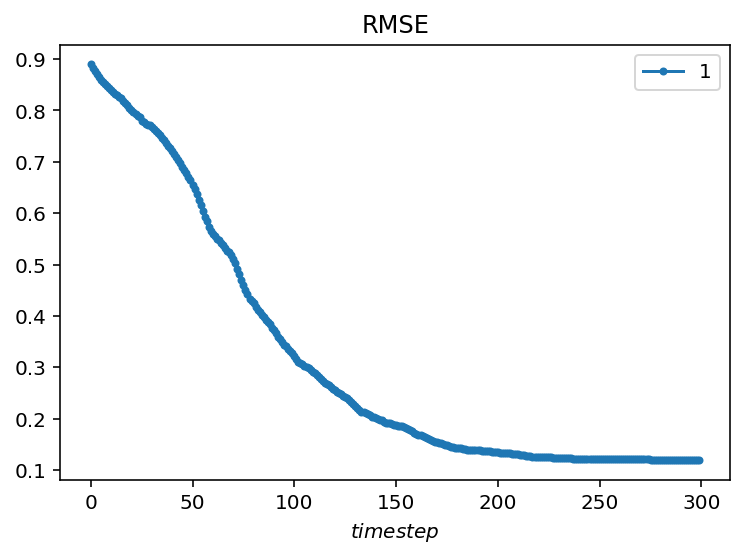

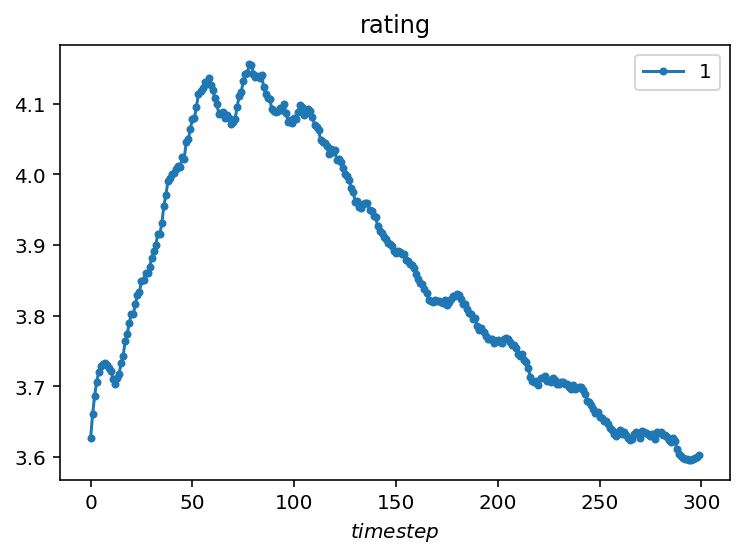

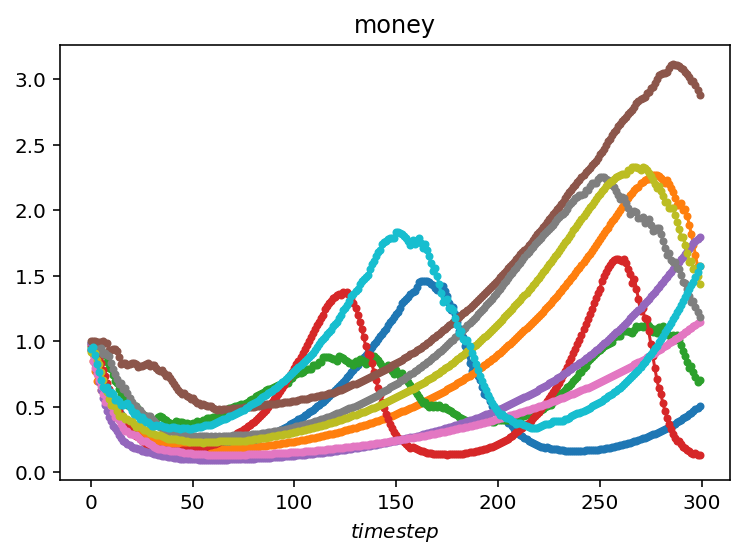

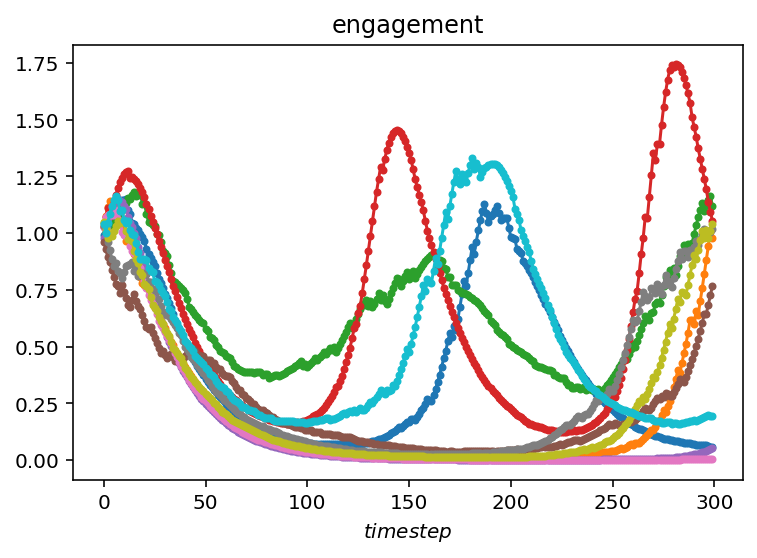

Average amount of money: 0.986831181969714
Average amount of engagement: 0.44235577932796133


In [23]:
NUM_USERS = 300
STEPS = 300
DIM = 5

# initialize environment and recommender
env = LatentFactorBehavior_MLHB(latent_dim=DIM, 
                           num_users=NUM_USERS,
                           num_items=NUM_USERS,
                           affinity_change=0,
                           rating_frequency=0.2,
                           num_init_ratings=NUM_USERS*NUM_USERS//100)

recommender = LibFM_MLHB(type='eps_greedy',
                    eps=float(0.3),
                    num_user_features=0,
                    num_item_features=0,
                    num_rating_features=0,
                    max_num_users=NUM_USERS,
                    max_num_items=NUM_USERS,
                    seed=0)
env.seed(0)
items, users, ratings = env.reset()
recommender.reset(items, users, ratings)
initialize_state(env, recommender)

# run simulation
losses, avg_ratings, users_features = simulation(env, recommender, steps=STEPS, retrain=True, callbacks=[RMSE, avg_rec_rating, update_state], reset=False)

# plot graphs
plot_graphs(losses, title='RMSE')
plot_graphs(avg_ratings, title="rating")
plot_graphs(np.array(users_features)[:, :10, 0].tolist(), title='money', legend=False, smooth=False)
plot_graphs(np.array(users_features)[:, :10, 1].tolist(), title='engagement', legend=False, smooth=False)

print("Average amount of money: " + str(np.mean(np.array(users_features)[:, :, 0])))
print("Average amount of engagement: " + str(np.mean(np.array(users_features)[:, :, 1])))

```
Answer: The average engagement increased by 10% as we anticipated. Interestingly, the average money also increased. For us, this exercise demonstrates the importance of exploration; exploiting the knowledge of the data distribution is simply not enough in a changing environment!
```